In [9]:
# testing out issues with mps
import torch
import platform
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


print("Python:", platform.python_version())
print("macOS:", platform.mac_ver())
print("Machine:", platform.machine())
print("MPS Built:", torch.backends.mps.is_built())
print("MPS Available:", torch.backends.mps.is_available())
print("Torch Version:", torch.__version__)


Python: 3.11.12
macOS: ('14.3', ('', '', ''), 'arm64')
Machine: arm64
MPS Built: True
MPS Available: True
Torch Version: 2.9.0


In [2]:
#loading packages and our data
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
       

# Load the data
pop = pd.read_csv('data/songs_kword_LIWC.csv')
pop.columns

Index(['title', 'artist', 'lyrics', 'num_days', 'avg_pos', 'max_pos',
       'Segment', 'WC', 'Analytic', 'Clout',
       ...
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark', 'Exclam',
       'Apostro', 'OtherP', 'Emoji'],
      dtype='object', length=125)

In [23]:
# processing: currently leaving punctuation alone
#note: sometimes this needs loaded twice
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

pop['lyrics'] = pop['lyrics'].astype(str).apply(remove_stopwords)
pop['lyrics-tokenized'] = pop['lyrics'].apply(simple_preprocess)


In [4]:
# # emotion detection with distilroberta
# # https://huggingface.co/j-hartmann/emotion-english-distilroberta-base
# # Load model and tokenizer

# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


# from transformers import pipeline
# emotion_model = pipeline(
#     "text-classification",
#     model="j-hartmann/emotion-english-distilroberta-base",
#     truncation=True 
# )

# # Process the entire column in batch (more efficient than applying row by row)
# predictions = emotion_model(pop['lyrics'].tolist(), batch_size=8)

In [3]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from tqdm import tqdm

# Ensure MPS is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Load model and tokenizer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()
id2label = model.config.id2label

# Define chunking function
def chunk_text(text, tokenizer, max_length=512, stride=256):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    chunks = []
    for i in range(0, len(input_ids), stride):
        chunk = input_ids[i:i+max_length]
        if len(chunk) < 5:
            continue
        chunks.append(chunk)
        if i + max_length >= len(input_ids):
            break
    return chunks

# Get lyrics list
lyrics_list = pop['lyrics'].astype(str).tolist()

# Process lyrics
all_labels = []
all_scores = []

with torch.no_grad():
    for lyric in tqdm(lyrics_list):
        token_chunks = chunk_text(lyric, tokenizer)
        emotions = []
        scores = []

        for chunk in token_chunks:
            input_tensor = torch.tensor([chunk]).to(device)
            attention_mask = torch.ones_like(input_tensor).to(device)
            outputs = model(input_ids=input_tensor, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=-1)
            pred_idx = torch.argmax(probs, dim=1).item()
            emotions.append(id2label[pred_idx])
            scores.append(probs[0, pred_idx].item())

        if emotions:
            most_common_emotion = pd.Series(emotions).mode().iloc[0]
            avg_score = sum(scores) / len(scores)
        else:
            most_common_emotion = None
            avg_score = None

        all_labels.append(most_common_emotion)
        all_scores.append(avg_score)

# Add predictions to DataFrame
pop['emotion'] = all_labels
pop['emotion_score'] = all_scores


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  3%|▎         | 319/9291 [00:41<19:31,  7.66it/s]


KeyboardInterrupt: 

In [ ]:
# # Add to DataFrame  
pop['emotion'] = all_labels
pop['emotion_score'] = all_scores

# Optional: create one-hot-style score columns for each emotion
for emotion in set(all_labels):
    pop[emotion] = pop.apply(lambda row: row['emotion_score'] if row['emotion'] == emotion else 0, axis=1)


In [25]:
# add NRC
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
import re
import string
from nrclex import NRCLex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

stop_words = set(stopwords.words('english'))

# Define cleaner
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove text in brackets (e.g., [Chorus])
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

# Emotion analysis function
def analyze_emotion(text):
    cleaned = clean_text(text)
    if cleaned:
        emotion_lexicon = NRCLex(cleaned)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {}

# Apply to your DataFrame
pop['emotion_scores_nrc'] = pop['lyrics'].apply(analyze_emotion)


ModuleNotFoundError: No module named 'nrclex'

In [4]:
# Math on what we have/identifying possible issues

# Total rows
total_rows = pop.shape[0]

# Count of valid dicts
valid_dicts = pop['emotion_scores_nrc'].apply(lambda x: isinstance(x, dict) and len(x) > 0).sum()

# Count of empty dicts
empty_dicts = pop['emotion_scores_nrc'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()

# Count of NaNs or None
null_values = pop['emotion_scores_nrc'].isna().sum()

# Summary
print(f"Total rows: {total_rows}")
print(f"Valid emotion dicts: {valid_dicts}")
print(f"Empty emotion dicts: {empty_dicts}")
print(f"Missing (NaN/None): {null_values}")
print(f"Total accounted for: {valid_dicts + empty_dicts + null_values}")


KeyError: 'emotion_scores_nrc'

In [ ]:
# from bertopic import BERTopic
# from umap import UMAP
# import hdbscan
# import pandas as pd

# # Prepare lyrics data
# lyrics = pop['lyrics'].dropna().astype(str).tolist()

# # Custom UMAP for more refined topic separation
# umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# # HDBSCAN with prediction_data enabled
# hdbscan_model = hdbscan.HDBSCAN(
#     min_cluster_size=10,
#     min_samples=1,
#     metric='euclidean',
#     cluster_selection_method='eom',
#     prediction_data=True  # 🛠️ Required for probabilities
# )

# # Create and fit BERTopic model
# topic_model = BERTopic(
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     calculate_probabilities=True,
#     verbose=True
# )

# # Fit model
# topics, probs = topic_model.fit_transform(lyrics)

# # Assign topics to dataframe
# pop['topic'] = topics

# # Show topic info
# print(topic_model.get_topic_info())


In [ ]:
from nrclex import NRCLex

# Define NRC emotion analyzer
def analyze_emotion(text):
    if isinstance(text, str):
        emotion_lexicon = NRCLex(text)
        return emotion_lexicon.raw_emotion_scores
    else:
        return {}

# Apply NRC analysis to lyrics
pop['emotion_scores_nrc'] = pop['lyrics'].apply(analyze_emotion)

# Convert dictionary of emotions to DataFrame
emotion_df = pop['emotion_scores_nrc'].apply(pd.Series).fillna(0)

# Define expected NRC columns
nrc_cols = ['anger_nrc', 'fear_nrc', 'joy_nrc', 'sadness_nrc', 'surprise_nrc',
            'disgust_nrc', 'trust_nrc', 'anticipation_nrc', 'negative_nrc', 'positive_nrc']

# Ensure emotion_df has all expected columns (even if some are missing from raw scores)
for col in nrc_cols:
    if col not in emotion_df.columns:
        emotion_df[col] = 0

# Reorder columns and drop existing NRC columns from pop if they exist
emotion_df = emotion_df[nrc_cols]
pop = pop.drop(columns=[col for col in nrc_cols if col in pop.columns])

# Add NRC emotion scores to pop
pop[nrc_cols] = emotion_df


In [24]:
# now LIWC, NRC, distilbert all together : time for Factor Analysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

pop_num = pop.select_dtypes(include='number')

# NEED TO LOOK AT THIS RE  NA VALUES 
pop_num_clean = pop_num.dropna() 
print(f"Rows before: {pop_num.shape[0]}, after dropna: {pop_num_clean.shape[0]}")
pop_num_clean = pop_num_clean.loc[:, pop_num_clean.std() != 0]
print((pop_num_clean.std() == 0).sum()) 


chi_square_value,p_value=calculate_bartlett_sphericity(pop_num_clean)
chi_square_value, p_value

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
# https://www.datacamp.com/tutorial/introduction-factor-analysis

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(pop_num_clean)
print("kmo: ", kmo_model) # nan--issues



Rows before: 9291, after dropna: 9231
0
kmo:  0.4426788680055123


In [4]:
# too many columns and not ready for factor analysis
from sklearn.feature_selection import VarianceThreshold

# Remove columns with zero or near-zero variance
selector = VarianceThreshold(threshold=1e-5)
filtered_data = selector.fit_transform(pop_num_clean)

# Optionally get remaining column names
remaining_cols = pop_num_clean.columns[selector.get_support()]
pop_num_filtered = pd.DataFrame(filtered_data, columns=remaining_cols)
pop_num_filtered.drop("Segment", inplace=True, axis=1, errors='ignore')

#note had to edit error = sp. in factor analyzer.py to error = np. 


In [ ]:
# identify low-loading factors to remove
from factor_analyzer import FactorAnalyzer

# Perform Factor Analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(pop_num_filtered)

# Get factor loadings
loadings = fa.loadings_

# Set a threshold for removing low loadings
threshold = 0.4

# Identify columns (items) with low factor loadings
low_loading_items = [pop_num_clean.columns[i] for i in range(loadings.shape[0]) if all(abs(loadings[i, :]) < threshold)]

print(f"Items with low factor loadings (below {threshold}):")
print(low_loading_items)

# Remove those items from the original DataFrame
pop_num_concise = pop_num_clean.drop(columns=low_loading_items)

# Check the cleaned dataset
print(f"DataFrame after removing low loading items: {pop_num_concise.shape}")

print(f"Remaining columns after removing low loading items: {pop_num_concise.columns.tolist()}")


c:\Users\Alejandro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Items with low factor loadings (below 0.4):
['num_days', 'avg_pos', 'max_pos', 'WC', 'Clout', 'Tone', 'WPS', 'BigWords', 'i', 'we', 'shehe', 'they', 'ipron', 'det', 'number', 'prep', 'conj', 'negate', 'adj', 'quantity', 'Drives', 'affiliation', 'achieve', 'power', 'allnone', 'insight', 'cause', 'discrep', 'tentat', 'certitude', 'differ', 'memory', 'Affect', 'tone_pos', 'tone_neg', 'emo_pos', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'swear', 'socbehav', 'prosocial', 'polite', 'conflict', 'moral', 'comm', 'family', 'friend', 'female', 'male', 'Culture', 'politic', 'ethnicity', 'tech', 'Lifestyle', 'leisure', 'home', 'work', 'money', 'relig', 'Physical', 'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 'food', 'death', 'need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue', 'reward', 'risk', 'curiosity', 'allure', 'attention', 'motion', 'visual', 'auditory', 'feeling', 'time', 'focuspast', 'focuspresent', 'focusfuture', 'netspeak', 'assent', 'nonflu', 'filler', 'Pe

In [5]:
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Set threshold and number of factors
threshold = 0.25
n_factors = 2

# Standardize the data
scaler = StandardScaler()
pop_scaled = scaler.fit_transform(pop_num_filtered)

# Convert back to DataFrame to keep column names
pop_scaled_df = pd.DataFrame(pop_scaled, columns=pop_num_filtered.columns)

# Work on a copy for iterative elimination
pop_num_concise = pop_scaled_df.copy()

for round_num in range(1, 6):  # Run 5 rounds
    print(f"\n--- Round {round_num} ---")

    # Fit Factor Analysis
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(pop_num_concise)

    # Get loadings
    loadings = fa.loadings_

    # Identify low-loading items
    low_loading_items = [
        pop_num_concise.columns[i]
        for i in range(loadings.shape[0])
        if all(abs(loadings[i, :]) < threshold)
    ]

    print(f"Low-loading items (below {threshold}): {low_loading_items}")

    # Drop low-loading items
    pop_num_concise.drop(columns=low_loading_items, inplace=True)

    print(f"Remaining columns after round {round_num}: {pop_num_concise.columns.tolist()}")






--- Round 1 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Low-loading items (below 0.25): ['num_days', 'avg_pos', 'max_pos', 'WC', 'Clout', 'Tone', 'WPS', 'BigWords', 'we', 'shehe', 'they', 'ipron', 'number', 'adj', 'quantity', 'Drives', 'affiliation', 'achieve', 'power', 'cause', 'certitude', 'memory', 'tone_pos', 'tone_neg', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'prosocial', 'polite', 'conflict', 'moral', 'family', 'friend', 'female', 'male', 'Culture', 'politic', 'ethnicity', 'tech', 'Lifestyle', 'leisure', 'home', 'work', 'money', 'relig', 'Physical', 'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 'food', 'death', 'need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue', 'reward', 'risk', 'curiosity', 'allure', 'attention', 'motion', 'visual', 'auditory', 'feeling', 'time', 'focuspast', 'nonflu', 'filler', 'Period', 'QMark', 'Exclam']
Remaining columns after round 1: ['Analytic', 'Authentic', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'you', 'det', 'article', 'prep', 'auxverb', 'adverb', 'conj', '

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Low-loading items (below 0.25): ['Affect', 'emotion', 'emo_pos', 'swear', 'focusfuture']
Remaining columns after round 2: ['Analytic', 'Authentic', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'you', 'det', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'Cognition', 'allnone', 'cogproc', 'insight', 'discrep', 'tentat', 'differ', 'Social', 'socbehav', 'comm', 'socrefs', 'Perception', 'space', 'focuspresent', 'Conversation', 'netspeak', 'assent', 'AllPunc', 'Comma', 'Apostro', 'OtherP']

--- Round 3 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Low-loading items (below 0.25): ['comm']
Remaining columns after round 3: ['Analytic', 'Authentic', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'you', 'det', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'Cognition', 'allnone', 'cogproc', 'insight', 'discrep', 'tentat', 'differ', 'Social', 'socbehav', 'socrefs', 'Perception', 'space', 'focuspresent', 'Conversation', 'netspeak', 'assent', 'AllPunc', 'Comma', 'Apostro', 'OtherP']

--- Round 4 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Low-loading items (below 0.25): ['allnone', 'socbehav']
Remaining columns after round 4: ['Analytic', 'Authentic', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'you', 'det', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'Cognition', 'cogproc', 'insight', 'discrep', 'tentat', 'differ', 'Social', 'socrefs', 'Perception', 'space', 'focuspresent', 'Conversation', 'netspeak', 'assent', 'AllPunc', 'Comma', 'Apostro', 'OtherP']

--- Round 5 ---


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Low-loading items (below 0.25): []
Remaining columns after round 5: ['Analytic', 'Authentic', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'you', 'det', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'Cognition', 'cogproc', 'insight', 'discrep', 'tentat', 'differ', 'Social', 'socrefs', 'Perception', 'space', 'focuspresent', 'Conversation', 'netspeak', 'assent', 'AllPunc', 'Comma', 'Apostro', 'OtherP']


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


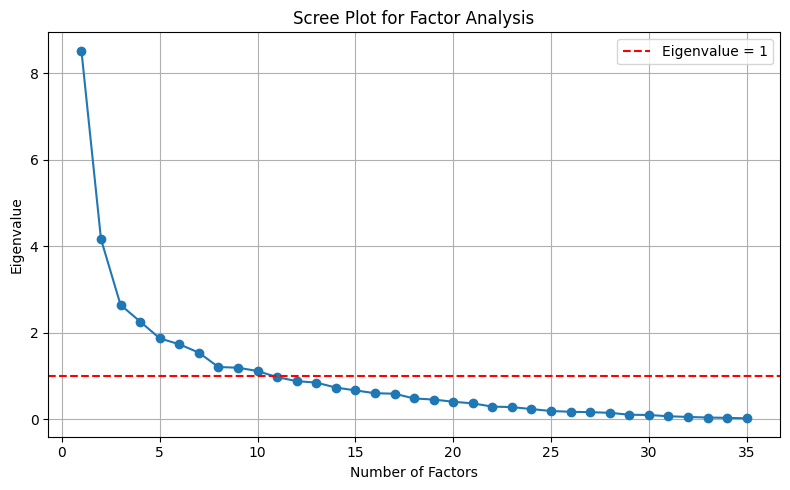

In [6]:
# determine the number of factors
# 
import matplotlib.pyplot as plt

# Fit FactorAnalyzer with max possible factors
fa = FactorAnalyzer(n_factors=pop_num_concise.shape[1], rotation='varimax')
fa.fit(pop_num_concise)

# Get eigenvalues and plot them
ev, _ = fa.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev)+1), ev, marker='o', linestyle='-')
plt.axhline(1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot for Factor Analysis')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Prepare for Factor Analysis on the smaller set of columns
# redo our calculations:
pop_num_concise = pop_num_clean[['Analytic', 'Linguistic',  'Cognition', 'swear', 'WC']].dropna()
#print(pop_num_concise.corr())
pop_num_concise = pop_num_concise.dropna()
#pop_num_concise.drop("Segment", axis=1, inplace=True)

#does it do better than identity matrix?
chi_square_value, p_value = calculate_bartlett_sphericity(pop_num_concise)
print("Bartlett’s Test: p =", p_value, "Chi-square =", chi_square_value)

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
# https://www.datacamp.com/tutorial/introduction-factor-analysis

#KMO calculations
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(pop_num_concise)
kmo_model # 0.6 is not very good, 0.7 is acceptable, 0.8 is good, 0.9 is great
# https://bookdown.org/luguben/EFA_in_R/kaiser-meyer-olkin-kmo.html

Bartlett’s Test: p = 0.0 Chi-square = 9694.272339070185


0.6854991194398947

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


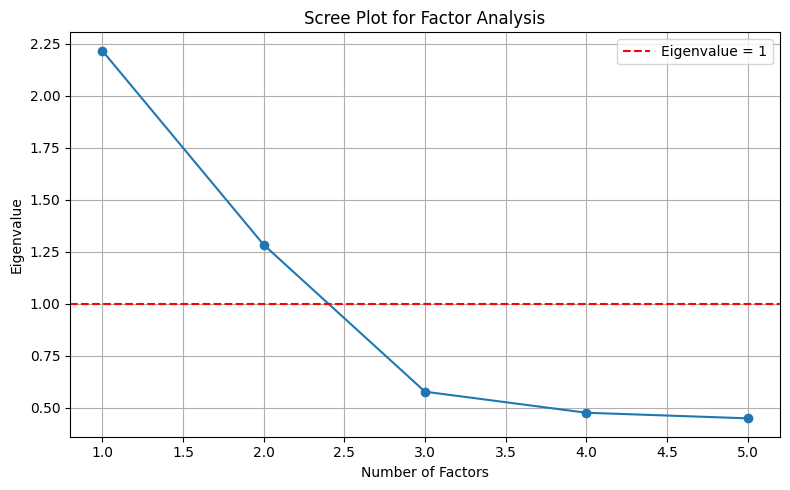

In [8]:
# determine the number of factors
# 
import matplotlib.pyplot as plt

# Fit FactorAnalyzer with max possible factors
fa = FactorAnalyzer(n_factors=pop_num_concise.shape[1], rotation='varimax')
fa.fit(pop_num_concise)

# Get eigenvalues and plot them
ev, _ = fa.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev)+1), ev, marker='o', linestyle='-')
plt.axhline(1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot for Factor Analysis')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# ready for factor analysis:
# redo but limit to 2 factors
fa = FactorAnalyzer(n_factors=2, rotation='varimax') 
fa.fit(pop_num_concise)

# Get the variance explained
variance, proportion_variance, cumulative_variance = fa.get_factor_variance()

# Print variance results
print("Variance per factor:", variance)
print("Proportion of variance per factor:", proportion_variance)
print("Cumulative variance (proportion):", cumulative_variance)


Variance per factor: [1.60431858 0.86264422]
Proportion of variance per factor: [0.32086372 0.17252884]
Cumulative variance (proportion): [0.32086372 0.49339256]


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[            Factor 1  Factor 2
swear      -0.135587  0.681430
WC         -0.067390  0.603188
Analytic   -0.745473  0.041982
Linguistic  0.729615 -0.114321
Cognition   0.702371 -0.140109]


<Figure size 1000x600 with 0 Axes>

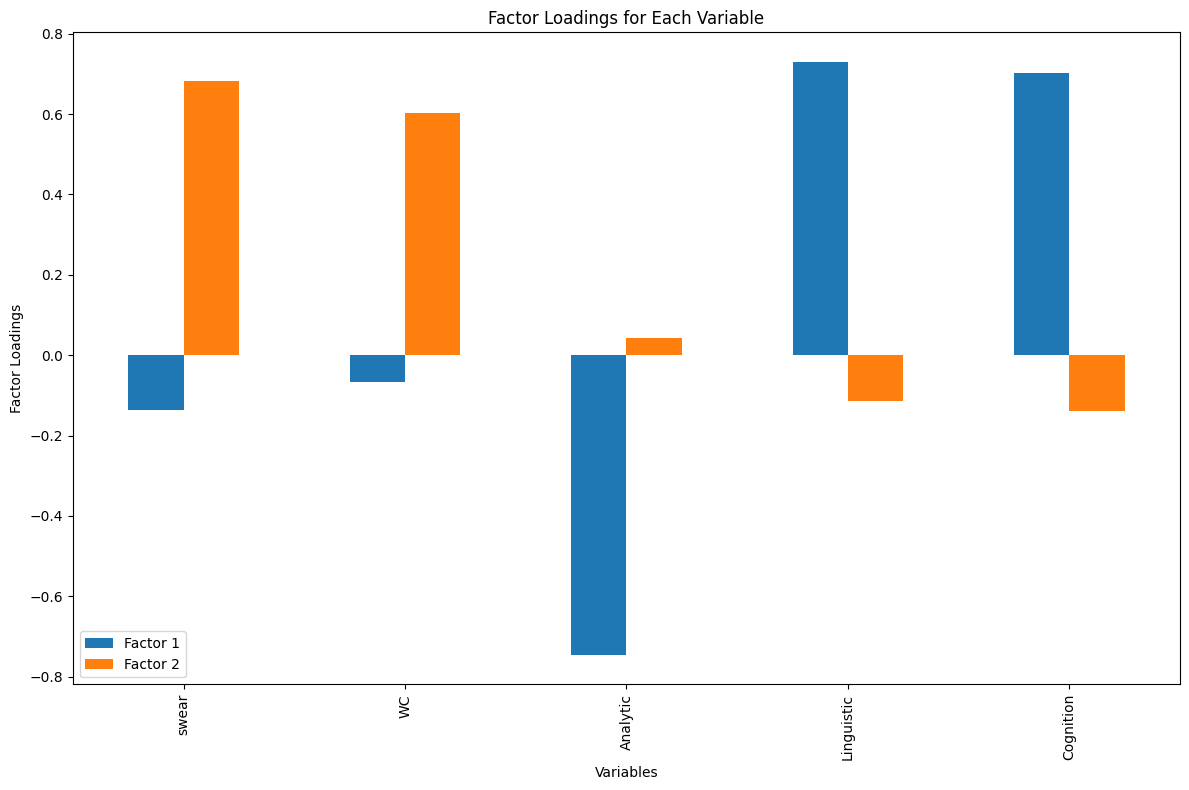

In [12]:
# look at loadings
import seaborn as sns

loadings = fa.loadings_

# Create a DataFrame for factor loadings for easier visualization
loadings_df = pd.DataFrame(loadings, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])], index=pop_num_concise.columns)
sorted_loadings_df = loadings_df.sort_values(by='Factor 2', ascending=False)


# Print factor loadings for each variable
print([sorted_loadings_df.head(10)])

# Plot bar chart of loadings for each variable in each factor
plt.figure(figsize=(10, 6))
# Set the axis limits for zooming in
sorted_loadings_df.plot(kind='bar', figsize=(12, 8))
plt.title("Factor Loadings for Each Variable")
plt.xlabel("Variables")
plt.ylabel("Factor Loadings")
plt.xticks(rotation=90)  # Rotate variable names for readability
plt.tight_layout()
plt.show()




/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


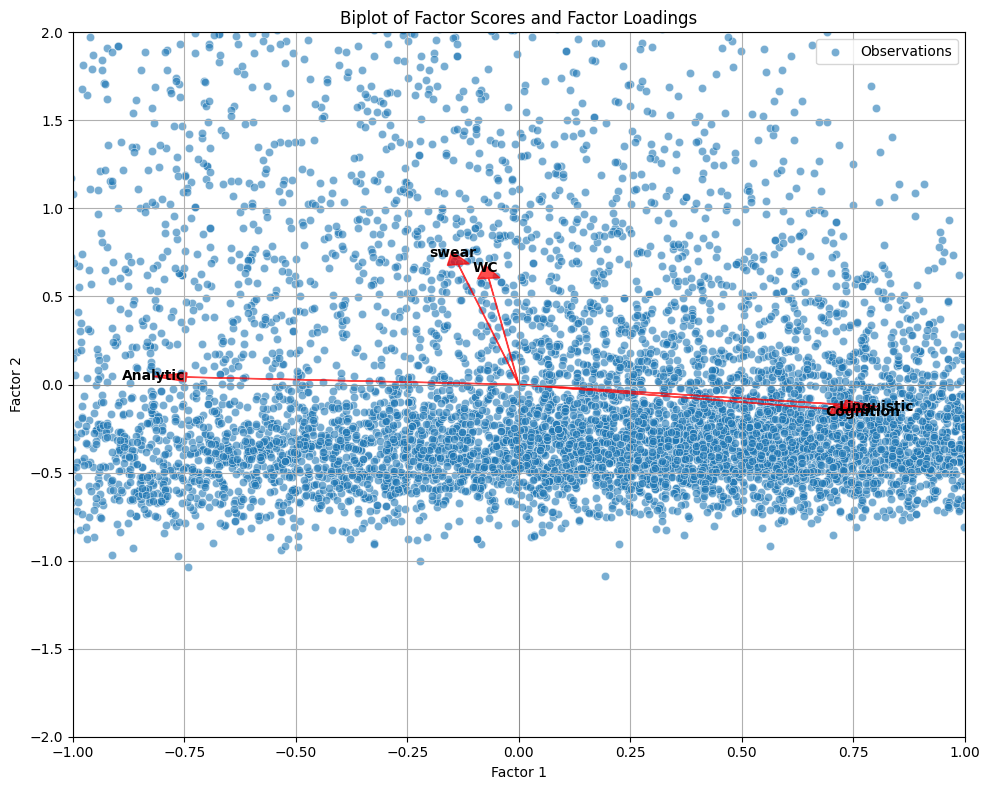

In [13]:
# look more at loadings and results: biplot
# biplot
import matplotlib.pyplot as plt
factor_scores = fa.transform(pop_num_concise)

# Create a biplot: Factor scores (observations) and factor loadings (variables)
plt.figure(figsize=(10, 8))

# Plot factor scores
sns.scatterplot(x=factor_scores[:, 0], y=factor_scores[:, 1], alpha=0.6, label='Observations')

# Plot factor loadings (arrows for variables)
for i, var in enumerate(loadings_df.index):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, var, color='black', ha='center', va='center', fontweight='bold')

# Labels and title
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
# Set the axis limits for zooming in
plt.xlim(-1, 1)
plt.ylim(-2, 2)
plt.title('Biplot of Factor Scores and Factor Loadings')
plt.axhline(0, color='gray',linewidth=0.5)
plt.axvline(0, color='gray',linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()


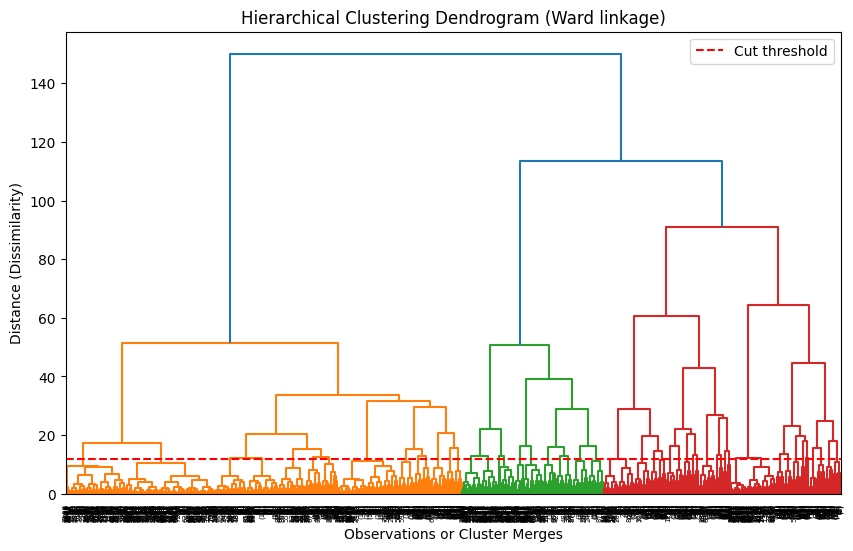

In [15]:
# --- Hierarchical Clustering on pop_num_concise ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1️⃣ Standardize the data (important!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pop_num_concise)

# 2️⃣ Compute the linkage matrix
# 'ward' minimizes variance within clusters — great for continuous data
Z = linkage(X_scaled, method='ward')

# 3️⃣ Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode="level", p=10)  # p=10 = show top merges
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Observations or Cluster Merges")
plt.ylabel("Distance (Dissimilarity)")
plt.axhline(y=12, color='r', linestyle='--', label="Cut threshold")  # optional cutoff
plt.legend()
plt.show()

In [17]:
# 4️⃣ Cut the dendrogram into clusters
# Option 1: specify cutoff distance
clusters = fcluster(Z, t=12, criterion='distance')

# Option 2: specify number of clusters directly
# clusters = fcluster(Z, t=3, criterion='maxclust')

# Add cluster labels to the original DataFrame
pop_num_concise_clustered = pop_num_concise.copy()
pop_num_concise_clustered["Cluster"] = clusters

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


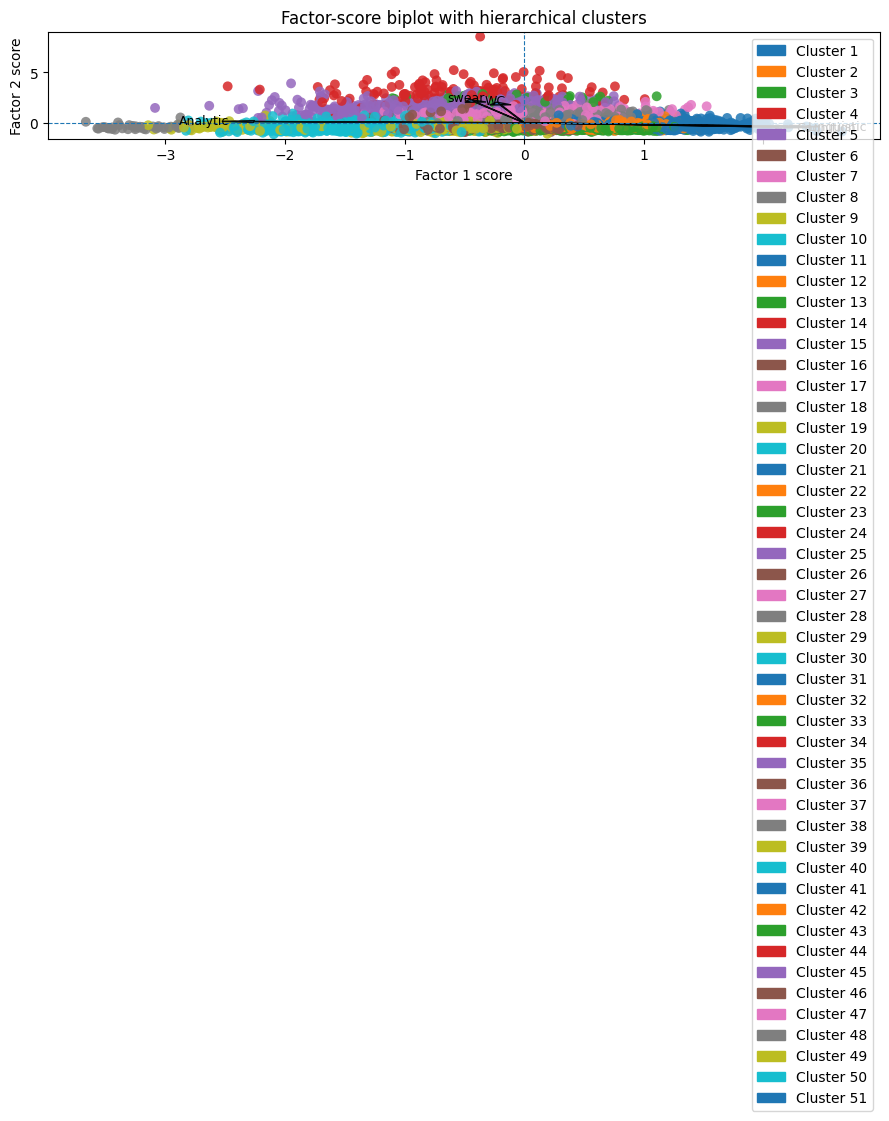

In [18]:
# --- Plot clusters on the factor-score biplot (2 factors) ---

import numpy as np
import matplotlib.pyplot as plt

# 1) Get factor scores (2D) and loadings from your fitted FactorAnalyzer `fa`
#    (Assumes `fa` was already fit with n_factors=2 on pop_num_concise)
factor_scores = fa.transform(pop_num_concise)              # shape: (n_samples, 2)
loadings = fa.loadings_[:, :2]                             # shape: (n_features, 2)
var_names = list(pop_num_concise.columns)

# 2) (Re)use your cluster labels computed earlier as `clusters`
#    If you prefer clustering directly on factor scores, do:
# from scipy.cluster.hierarchy import linkage, fcluster
# Z = linkage(factor_scores, method='ward')
# clusters = fcluster(Z, t=12, criterion='distance')

# 3) Biplot of factor scores colored by cluster
plt.figure(figsize=(9, 7))
scatter = plt.scatter(
    factor_scores[:, 0],
    factor_scores[:, 1],
    c=clusters,
    cmap='tab10',
    s=50,
    alpha=0.85,
    edgecolor='none'
)

plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("Factor-score biplot with hierarchical clusters")

# 4) Add loading vectors (arrows) with a reasonable scale so they fit the score cloud
#    Compute a scale based on the spread of scores to keep arrows visible but not huge.
score_range = np.max(np.ptp(factor_scores, axis=0))  # max range across F1/F2
arrow_scale = 0.35 * score_range                     # tweak if you want longer/shorter arrows

for i, (lx, ly) in enumerate(loadings):
    x_end = lx * arrow_scale
    y_end = ly * arrow_scale
    plt.arrow(0, 0, x_end, y_end, width=0.008, head_width=0.18, length_includes_head=True, alpha=0.9)
    # place the label slightly beyond the arrow tip
    plt.text(x_end * 1.06, y_end * 1.06, var_names[i], fontsize=9, ha='center', va='center')

# 5) Nice legend for clusters
#    Build custom handles so the legend shows "Cluster 1/2/..." cleanly.
import matplotlib.patches as mpatches
handles = []
for k in np.unique(clusters):
    handles.append(
        mpatches.Patch(color=plt.cm.tab10((k-1) % 10), label=f"Cluster {k}")
    )
plt.legend(handles=handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


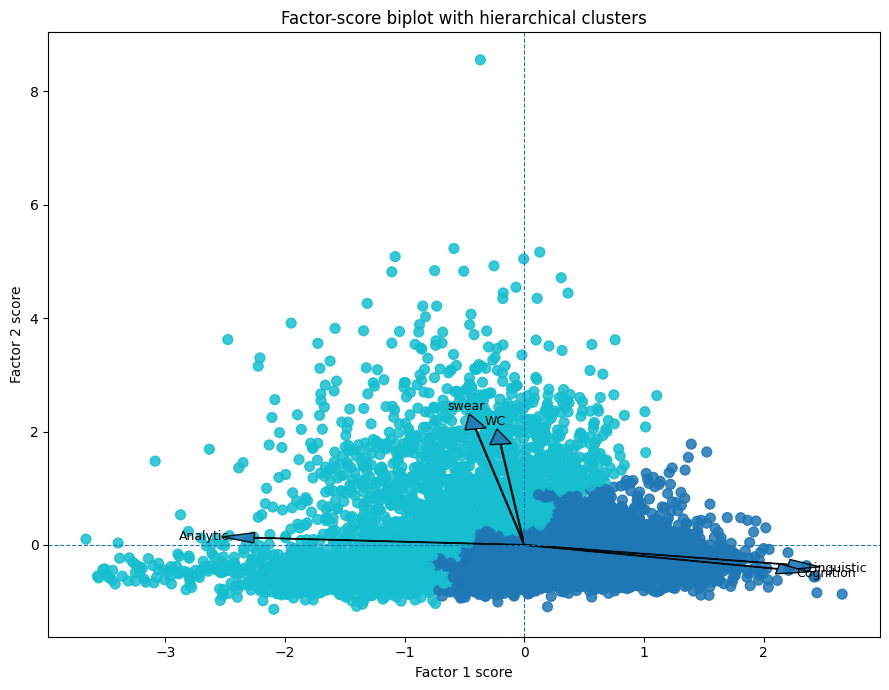

In [22]:
# Get factor scores and loadings
factor_scores = fa.transform(pop_num_concise)
loadings = fa.loadings_[:, :2]
var_names = list(pop_num_concise.columns)

# --- Add these lines ---
Z = linkage(factor_scores, method='ward')
clusters = fcluster(Z, t=2, criterion='maxclust')   # or use criterion='distance'
# -----------------------

# Plot
plt.figure(figsize=(9,7))
plt.scatter(factor_scores[:,0], factor_scores[:,1], c=clusters, cmap='tab10', s=50, alpha=0.85)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("Factor-score biplot with hierarchical clusters")

# Draw loading arrows
arrow_scale = 0.35 * np.max(np.ptp(factor_scores, axis=0))
for i, (lx, ly) in enumerate(loadings):
    plt.arrow(0, 0, lx*arrow_scale, ly*arrow_scale,
              width=0.008, head_width=0.18, length_includes_head=True, alpha=0.9)
    plt.text(lx*arrow_scale*1.06, ly*arrow_scale*1.06, var_names[i],
             fontsize=9, ha='center', va='center')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


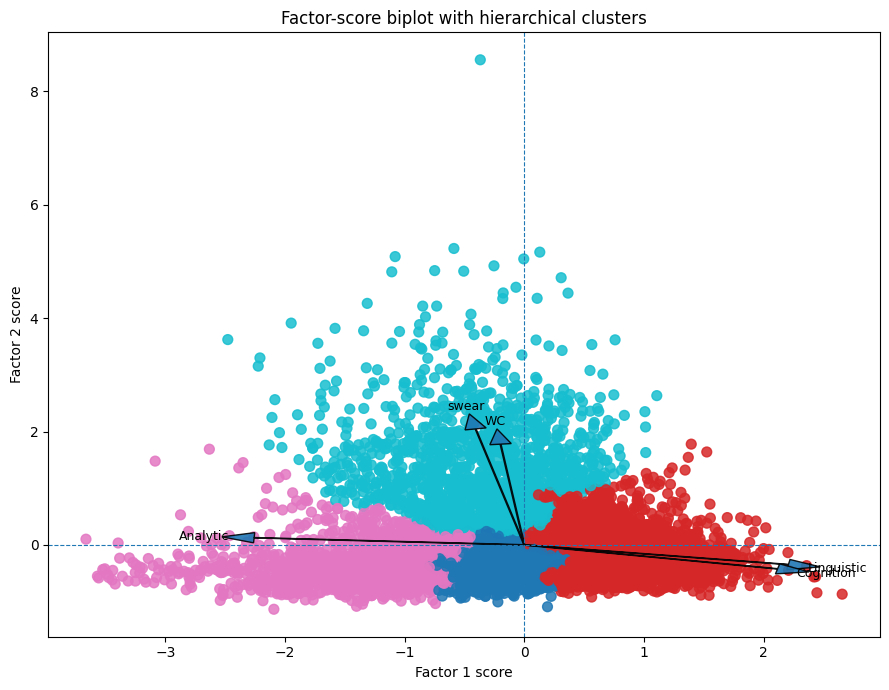

In [21]:
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import numpy as np

# Get factor scores and loadings
factor_scores = fa.transform(pop_num_concise)
loadings = fa.loadings_[:, :2]
var_names = list(pop_num_concise.columns)

# --- Add these lines ---
Z = linkage(factor_scores, method='ward')
clusters = fcluster(Z, t=4, criterion='maxclust')   # or use criterion='distance'
# -----------------------

# Plot
plt.figure(figsize=(9,7))
plt.scatter(factor_scores[:,0], factor_scores[:,1], c=clusters, cmap='tab10', s=50, alpha=0.85)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("Factor-score biplot with hierarchical clusters")

# Draw loading arrows
arrow_scale = 0.35 * np.max(np.ptp(factor_scores, axis=0))
for i, (lx, ly) in enumerate(loadings):
    plt.arrow(0, 0, lx*arrow_scale, ly*arrow_scale,
              width=0.008, head_width=0.18, length_includes_head=True, alpha=0.9)
    plt.text(lx*arrow_scale*1.06, ly*arrow_scale*1.06, var_names[i],
             fontsize=9, ha='center', va='center')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


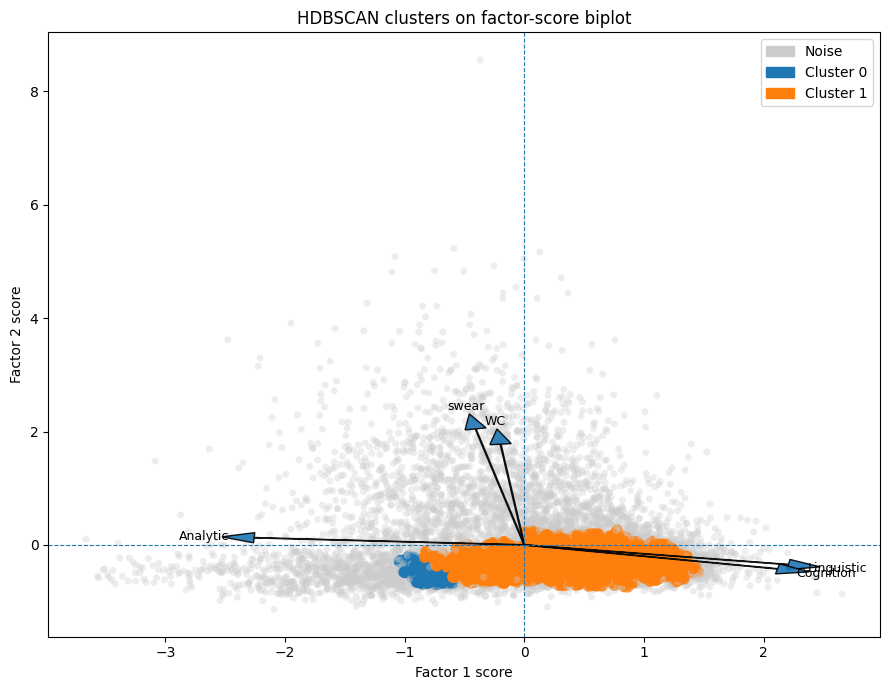

          n  avg_prob
label                
-1     4059  0.000000
 0      233  0.985384
 1     4939  0.954901


In [44]:
# --- HDBSCAN on factor scores + biplot with loadings ---

import numpy as np
import matplotlib.pyplot as plt
import hdbscan

# 1) Get factor scores (2D) and loadings from your fitted FactorAnalyzer `fa`
#    Assumes: fa.fit(pop_num_concise) was already done with n_factors=2
factor_scores = fa.transform(pop_num_concise)      # shape: (n_samples, 2)
loadings = fa.loadings_[:, :2]                     # shape: (n_features, 2)
var_names = list(pop_num_concise.columns)

# 2) Run HDBSCAN on the factor scores
#    Tune min_cluster_size / min_samples for your data density
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=120,      
    min_samples=5,         
    metric='euclidean',
    cluster_selection_method='eom'  # or 'leaf' for finer splits
)
labels = clusterer.fit_predict(factor_scores)      # -1 = noise
probs  = clusterer.probabilities_                  # membership strength in [0,1]

# 3) Build colors: one color per cluster, noise in light gray
unique_labels = np.unique(labels)
# Map labels (excluding -1) to tab10; noise -> lightgray
label_to_color = {}
palette = plt.cm.tab10.colors
ci = 0
for lab in unique_labels:
    if lab == -1:
        label_to_color[lab] = (0.8, 0.8, 0.8)      # light gray for noise
    else:
        label_to_color[lab] = palette[ci % len(palette)]
        ci += 1
colors = np.array([label_to_color[l] for l in labels])

# Optionally reflect membership strength in alpha/size
alphas = 0.35 + 0.65 * probs   # more confident points look bolder
sizes  = 25  + 55  * probs

# 4) Plot factor-score biplot colored by HDBSCAN clusters
plt.figure(figsize=(9, 7))
plt.scatter(
    factor_scores[:, 0], factor_scores[:, 1],
    c=colors, s=sizes, alpha=alphas, edgecolor='none'
)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("HDBSCAN clusters on factor-score biplot")

# 5) Overlay loading vectors (arrows) for interpretability
score_range = np.max(np.ptp(factor_scores, axis=0))
arrow_scale = 0.35 * score_range   # tweak if arrows too short/long

for i, (lx, ly) in enumerate(loadings):
    x_end = lx * arrow_scale
    y_end = ly * arrow_scale
    plt.arrow(0, 0, x_end, y_end,
              width=0.008, head_width=0.18,
              length_includes_head=True, alpha=0.9)
    plt.text(x_end * 1.06, y_end * 1.06, var_names[i],
             fontsize=9, ha='center', va='center')

# 6) Legend for clusters (including noise)
import matplotlib.patches as mpatches
handles = []
for lab in unique_labels:
    name = "Noise" if lab == -1 else f"Cluster {lab}"
    handles.append(mpatches.Patch(color=label_to_color[lab], label=name))
plt.legend(handles=handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

# 7) (Optional) Inspect cluster sizes and confidences
import pandas as pd
summary = pd.DataFrame({
    "label": labels,
    "prob": probs
}).groupby("label").agg(n=("label", "size"), avg_prob=("prob", "mean")).sort_index()
print(summary)

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


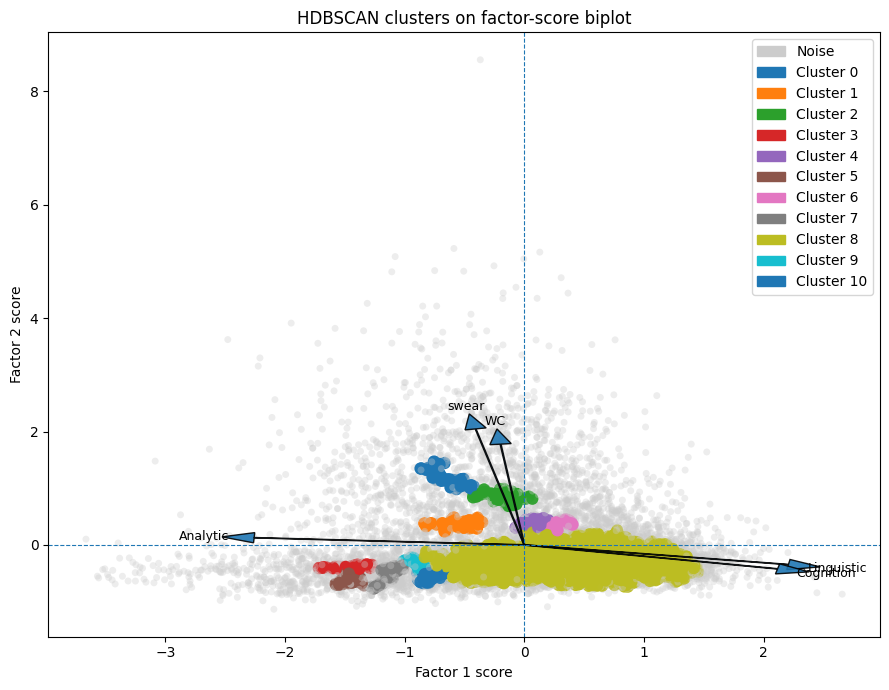

          n  avg_prob
label                
-1     3717  0.000000
 0       41  0.999782
 1       52  0.998154
 2       70  0.978817
 3       41  0.999709
 4       55  0.999281
 5       50  0.994808
 6       41  0.999764
 7       61  0.995236
 8     4939  0.981304
 9       56  0.975276
 10     108  0.968514


In [47]:
# --- HDBSCAN on factor scores + biplot with loadings ---

import numpy as np
import matplotlib.pyplot as plt
import hdbscan

# 1) Get factor scores (2D) and loadings from your fitted FactorAnalyzer `fa`
#    Assumes: fa.fit(pop_num_concise) was already done with n_factors=2
factor_scores = fa.transform(pop_num_concise)      # shape: (n_samples, 2)
loadings = fa.loadings_[:, :2]                     # shape: (n_features, 2)
var_names = list(pop_num_concise.columns)

# 2) Run HDBSCAN on the factor scores
#    Tune min_cluster_size / min_samples for your data density
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,      
    min_samples=5,         
    metric='euclidean',
    cluster_selection_method='eom'  # or 'leaf' for finer splits
)
labels = clusterer.fit_predict(factor_scores)      # -1 = noise
probs  = clusterer.probabilities_                  # membership strength in [0,1]

# 3) Build colors: one color per cluster, noise in light gray
unique_labels = np.unique(labels)
# Map labels (excluding -1) to tab10; noise -> lightgray
label_to_color = {}
palette = plt.cm.tab10.colors
ci = 0
for lab in unique_labels:
    if lab == -1:
        label_to_color[lab] = (0.8, 0.8, 0.8)      # light gray for noise
    else:
        label_to_color[lab] = palette[ci % len(palette)]
        ci += 1
colors = np.array([label_to_color[l] for l in labels])

# Optionally reflect membership strength in alpha/size
alphas = 0.35 + 0.65 * probs   # more confident points look bolder
sizes  = 25  + 55  * probs

# 4) Plot factor-score biplot colored by HDBSCAN clusters
plt.figure(figsize=(9, 7))
plt.scatter(
    factor_scores[:, 0], factor_scores[:, 1],
    c=colors, s=sizes, alpha=alphas, edgecolor='none'
)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("HDBSCAN clusters on factor-score biplot")

# 5) Overlay loading vectors (arrows) for interpretability
score_range = np.max(np.ptp(factor_scores, axis=0))
arrow_scale = 0.35 * score_range   # tweak if arrows too short/long

for i, (lx, ly) in enumerate(loadings):
    x_end = lx * arrow_scale
    y_end = ly * arrow_scale
    plt.arrow(0, 0, x_end, y_end,
              width=0.008, head_width=0.18,
              length_includes_head=True, alpha=0.9)
    plt.text(x_end * 1.06, y_end * 1.06, var_names[i],
             fontsize=9, ha='center', va='center')

# 6) Legend for clusters (including noise)
import matplotlib.patches as mpatches
handles = []
for lab in unique_labels:
    name = "Noise" if lab == -1 else f"Cluster {lab}"
    handles.append(mpatches.Patch(color=label_to_color[lab], label=name))
plt.legend(handles=handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

# 7) (Optional) Inspect cluster sizes and confidences
import pandas as pd
summary = pd.DataFrame({
    "label": labels,
    "prob": probs
}).groupby("label").agg(n=("label", "size"), avg_prob=("prob", "mean")).sort_index()
print(summary)

#### clustering methods
1. use categorical variable (genre) to color-code the observations and then see how they relate to quadrants/arrows
2. hierarchical clustering
3. hbdscan

#### interpretation
1. mean factor scores for each cluster
2. proximity to loading vectors for each cluster
3. relation to other categorical variables (genre)


## K-Means: clustering of factor results

100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


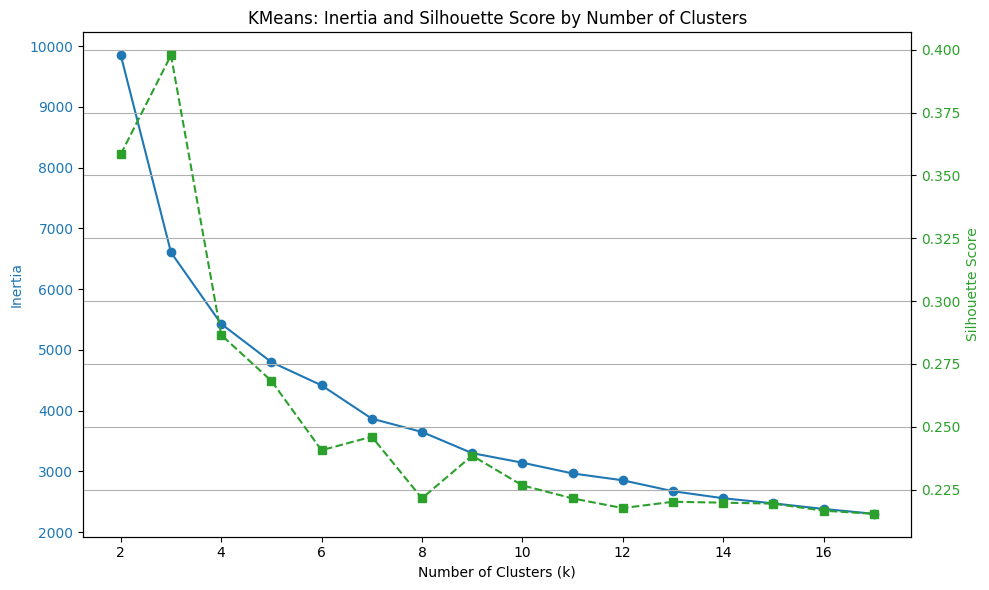

k	Inertia		Silhouette Score
2	9848.72		0.358
3	6603.15		0.398
4	5426.97		0.287
5	4797.20		0.268
6	4414.74		0.241
7	3866.47		0.246
8	3647.72		0.222
9	3298.55		0.239
10	3141.49		0.227
11	2964.89		0.222
12	2851.59		0.218
13	2671.81		0.220
14	2556.33		0.220
15	2471.86		0.219
16	2380.25		0.217
17	2300.18		0.215


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of cluster sizes to evaluate
k_range = range(2, 18)

# Store inertia and silhouette scores
inertias = []
silhouette_scores = []

# Fit KMeans for each k and record metrics
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=13)
    kmeans.fit(factor_scores)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil_score = silhouette_score(factor_scores, labels)
    silhouette_scores.append(sil_score)

# Plot both inertia and silhouette score
fig, ax1 = plt.subplots(figsize=(10, 6))

# Inertia plot
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(k_range, inertias, marker='o', label='Inertia', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Silhouette score plot (secondary axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:green')
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='--', label='Silhouette Score', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('KMeans: Inertia and Silhouette Score by Number of Clusters')
plt.grid(True)
fig.tight_layout()
plt.show()

# Optional: Print both metrics in tabular form
print("k\tInertia\t\tSilhouette Score")
for i, k in enumerate(k_range):
    print(f"{k}\t{inertias[i]:.2f}\t\t{silhouette_scores[i]:.3f}")


In [ ]:
# commit to clusters
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

kmeans_4 = KMeans(n_clusters=3, random_state=13)
clusters4 = kmeans_4.fit_predict(factor_scores)



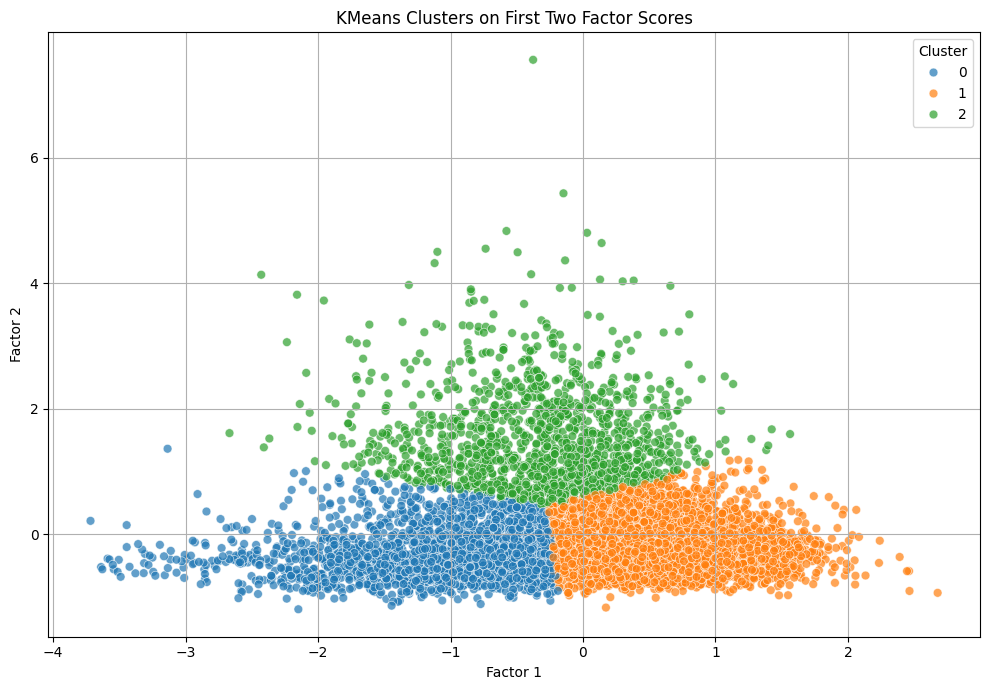

In [ ]:
# visualize clusters

# Convert factor scores to a DataFrame if it's not already
factor_df = pd.DataFrame(factor_scores, columns=[f'Factor {i+1}' for i in range(factor_scores.shape[1])])
factor_df['Cluster'] = clusters4  # Add KMeans cluster labels

# Plot first two factors
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Factor 1', y='Factor 2',
    hue='Cluster',
    palette='tab10',
    data=factor_df,
    alpha=0.7,
    s=40
)
plt.title("KMeans Clusters on First Two Factor Scores")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


# # Visualize with colors
# sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=clusters5, palette="viridis", s=30)
# plt.title("UMAP of Factor Scores with Clusters")
# plt.show()

In [ ]:
from bertopic import BERTopic

# Step 1: Attach cluster labels to pop dataframe, ensuring alignment
pop_t =  pop_num_concise.join(pop['lyrics'], how='inner')
#pop_t['lyrics'] = pop['lyrics'].dropna()
#pop_t = pop.reset_index(drop=True)  # Ensure matching index
pop_t['Cluster'] = clusters4        # Add clusters to main dataframe

# Step 2: Initialize dictionary to store topic models per cluster
cluster_topic_models = {}

# Step 3: Loop through clusters and apply BERTopic
for cluster_id in sorted(pop_t['Cluster'].unique()):
    cluster_lyrics = pop_t[pop_t['Cluster'] == cluster_id]['lyrics'].dropna().astype(str).tolist()

    if len(cluster_lyrics) > 10:  # Skip clusters with very few entries
        print(f"\nFitting topic model for Cluster {cluster_id} with {len(cluster_lyrics)} documents...")
        topic_model = BERTopic()
        topics, probs = topic_model.fit_transform(cluster_lyrics)
        cluster_topic_models[cluster_id] = topic_model

        # Optionally print top topic
        print(topic_model.get_topic_info().head(3))



Fitting topic model for Cluster 0 with 2536 documents...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Topic  Count                          Name  \
0     -1      7  -1_wellerman_tonguin_tea_rum   
1      0   2279           0_like_im_yeah_love   
2      1    193           1_yeah_oh_love_that   

                                      Representation  \
0  [wellerman, tonguin, tea, rum, sugar, leave, s...   
1  [like, im, yeah, love, oh, got, its, dont, bab...   
2  [yeah, oh, love, that, im, dont, hey, me, ooh,...   

                                 Representative_Docs  
0  [lyrics ship sea ship billy tea winds blew up,...  
1  [clear blue water high tide came brought on, s...  
2  [i'm different type beast i'm different type b...  

Fitting topic model for Cluster 1 with 5387 documents...
   Topic  Count                      Name  \
0      0   5333       0_im_dont_know_yeah   
1      1     54  1_christmas_snow_oh_year   

                                      Representation  \
0  [im, dont, know, yeah, love, oh, like, its, yo...   
1  [christmas, snow, oh, year, santa, im, its, ma...

In [ ]:
# from sklearn.neighbors import NearestNeighbors
# import matplotlib.pyplot as plt
# import numpy as np

# neigh = NearestNeighbors(n_neighbors=5)
# nbrs = neigh.fit(pop_num_concise.drop(columns=['dbscan_cluster'], errors='ignore'))
# distances, indices = nbrs.kneighbors(pop_num_concise.drop(columns=['dbscan_cluster'], errors='ignore'))

# distances = np.sort(distances[:, 4])  # 4th NN
# plt.plot(distances)
# plt.axhline(y=0.5, color='r', linestyle='--')  # current eps
# plt.title("K-distance Plot (4th NN)")
# plt.xlabel("Data Points sorted by distance")
# plt.ylabel("4th Nearest Neighbor Distance")
# plt.grid(True)
# plt.show()


In [ ]:
# # Export as df:

# # Step 1: Filter out rows with missing values in keeper columns
# pop_clusters = pop[pop[['Cognition', 'Linguistic', 'swear', 'emo_pos']].notna().all(axis=1)].copy()

# # Step 2: Add the cluster labels
# pop_clusters['cluster'] = clusters5

# # Step 3: Create the factor scores DataFrame (factor_scores should be aligned with the same filtered rows)
# factor_df = pd.DataFrame(
#     factor_scores,
#     columns=[f'Factor {i+1}' for i in range(factor_scores.shape[1])],
#     index=pop_clusters.index  # <- Use pop_clusters index here for perfect alignment
# )

# # Step 4: Concatenate factor scores into pop_clusters
# pop_clusters = pd.concat([pop_clusters, factor_df], axis=1)

# # Step 5: Check the columns
# print(pop_clusters.columns.tolist())

# # Step 6: Load the CSV file and keep only the first two columns
# songs_df = pd.read_csv('data/songs_expanded_25_04_01.csv', usecols=[0, 1])

# # Step 7: Ensure index alignment — check and align if needed
# # Option 1: If index matches pop_clusters
# # pop_clusters = pop_clusters.merge(songs_df, left_index=True, right_index=True)

# # Option 2: If there's a common key column (e.g., 'song_id' or 'title'), merge on that
# # Replace 'key_column' with the actual shared column name
# # pop_clusters = pop_clusters.merge(songs_df, on='key_column', how='left')

# # Step 7 (recommended): Add the two columns directly, assuming order matches
# pop_clusters = pop_clusters.reset_index(drop=True)  # Ensure matching index
# songs_df = songs_df.reset_index(drop=True)

# pop_clusters = pd.concat([songs_df, pop_clusters], axis=1)

# # Step 8: Check final DataFrame
# print(pop_clusters.head())


In [ ]:
# ## UMAP
# import umap
# import matplotlib.pyplot as plt

# # Initialize UMAP
# for n in [5, 15, 30, 50]:
#     embedding = umap.UMAP(n_neighbors=n, random_state=13).fit_transform(pop_num_concise)
#     plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
#     plt.title(f'n_neighbors={n}')
#     plt.show()

# # Fit and transform the factor scores
# # umap_embedding = reducer.fit_transform(factor_scores)




In [ ]:
# import numpy as np
# import pandas as pd
# import umap
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# # Set up values to test
# neighbors_range = [5,  50, 75]
# silhouette_scores = []

# for n in neighbors_range:
#     # Step 1: UMAP projection
#     reducer = umap.UMAP(n_neighbors=n, n_components=2, random_state=13)
#     embedding = reducer.fit_transform(factor_scores)  # or your high-dim data

#     # Step 2: Clustering (adjust k as needed)
#     kmeans = KMeans(n_clusters=5, random_state=13)
#     labels = kmeans.fit_predict(embedding)

#     # Step 3: Silhouette score
#     score = silhouette_score(embedding, labels)
#     silhouette_scores.append(score)

# # Step 4: Plot the results
# plt.figure(figsize=(8, 5))
# plt.plot(neighbors_range, silhouette_scores, marker='o')
# plt.title("Silhouette Score vs n_neighbors")
# plt.xlabel("UMAP n_neighbors")
# plt.ylabel("Silhouette Score")
# plt.grid(True)
# plt.show()


In [ ]:
# from umap import UMAP
# factor_cols = [col for col in pop_clusters.columns if col.startswith('Factor')]

# # Step 2: Generate UMAP embeddings
# umap_model = UMAP(random_state=13)
# umap_embedding = umap_model.fit_transform(pop_clusters[factor_cols])

# # Step 3: Plot the scatterplot with hue by cluster
# plt.figure(figsize=(12, 8))
# sns.scatterplot(
#     x=umap_embedding[:, 0],
#     y=umap_embedding[:, 1],
#     hue=pop_clusters['cluster'],
#     palette='viridis',
#     s=30,
#     alpha=0.8,
#     edgecolor='none'
# )

# # Step 4: Add artist labels (optional: limit to avoid clutter)
# for i, artist in enumerate(pop_clusters.iloc[:10, 0]):  # 
#     plt.text(
#         umap_embedding[i, 0],
#         umap_embedding[i, 1],
#         str(artist),
#         fontsize=6,
#         alpha=0.6
#     )

# plt.title("UMAP of Factor Scores with Clusters and Artist Labels")
# plt.xlabel("UMAP Dimension 1")
# plt.ylabel("UMAP Dimension 2")
# plt.legend(title='Cluster')
# plt.tight_layout()
# plt.show()

In [ ]:
# print(pop_clusters.columns.tolist())

In [ ]:
# pop_clusters.to_csv('data/songs_expandedc_25_05_12.csv', index=False)



In [ ]:
# pop_clusters.describe(include='object')
# print(pop_clusters.columns.tolist())

In [ ]:
# pop_clusters = pd.read_csv('data/songs_expandedc_25_05_12.csv') 
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# keepers = ["function", "Cognition", "cogproc", "Linguistic", "WC","Comma", "swear","Analytic",
# "Social", "socrefs", "pronoun", "ppron", "space", "Perception", "article"]
# pop_clusters = pd.get_dummies(pop_clusters, columns=['emotion'], prefix='emotion')
# pop_clusters = pd.get_dummies(pop_clusters, columns=['artist'], drop_first=False)
# pop_clusters= pop_clusters.dropna()
# drops = keepers + ['album','cluster', 'lyrics', 'song', 'Tone','lyrics-tokenized','emotion_scores_nrc', 'Factor 1', 'Factor 2']
# #X = pop_clusters.drop(columns=drops)       # Features (e.g. factor scores, PCA, etc.)
# X = pop_clusters[['surprise', 'joy', 'anger', 'neutral', 'sadness', 'fear', 'disgust', 'anger_nrc', 'fear_nrc', 'joy_nrc', 'sadness_nrc', 'surprise_nrc', 'disgust_nrc', 'trust_nrc', 'anticipation_nrc', 'negative_nrc', 'positive_nrc']]
# y = pop_clusters['cluster']    


# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# # Train model
# clf = RandomForestClassifier(random_state=13)
# clf.fit(X_train, y_train)

# # Predict on test set
# y_pred = clf.predict(X_test)

# # Evaluate performance
# print(classification_report(y_test, y_pred))

In [ ]:
# importances = clf.feature_importances_
# features = X_train.columns

# # Create a Series for easy visualization
# feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

# # Top 10 important features
# feat_importance.head(10).plot(kind='barh')
# plt.title("Top 10 Feature Importances")
# plt.gca().invert_yaxis()
# plt.show()

## New work

In [ ]:
df = pop_num_filtered[['num_days', 'avg_pos', 'max_pos']]
df['Factor 1'] = factor_scores[:, 0]
df['Factor 2'] = factor_scores[:, 1]

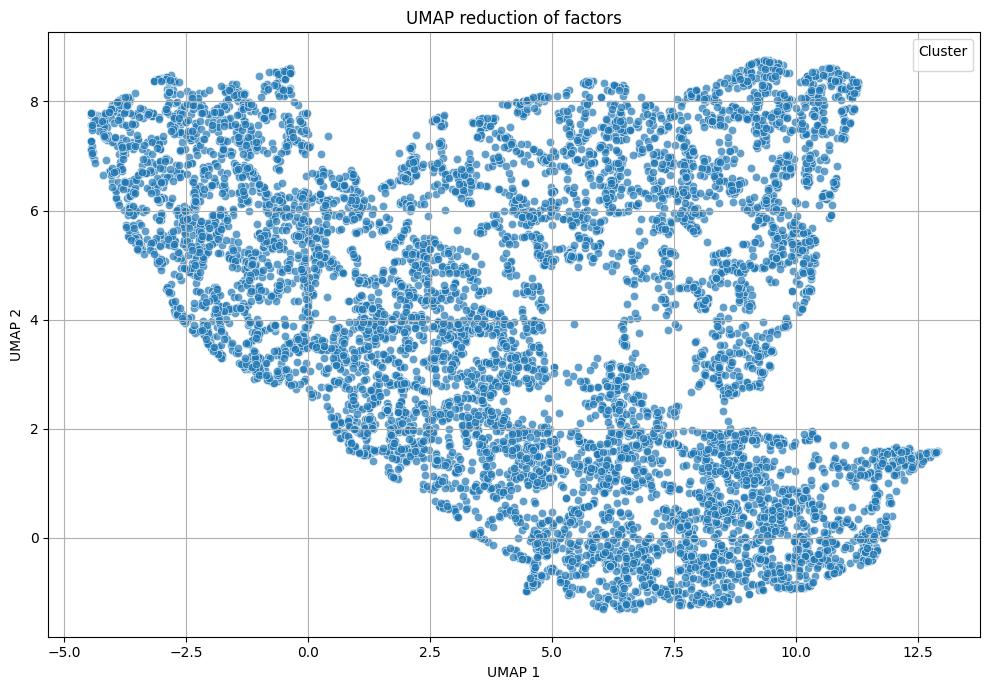

In [ ]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, random_state=13, min_dist=0.05, n_components=2)
umap_results = umap_model.fit_transform(factor_scores)
df['UMAP 1'] = umap_results[:, 0]
df['UMAP 2'] = umap_results[:, 1]

#graph
plt.figure(figsize=(10, 7))
sns.scatterplot(x='UMAP 1', y='UMAP 2', data=df, palette='viridis', alpha=0.7)
plt.title("UMAP reduction of factors")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


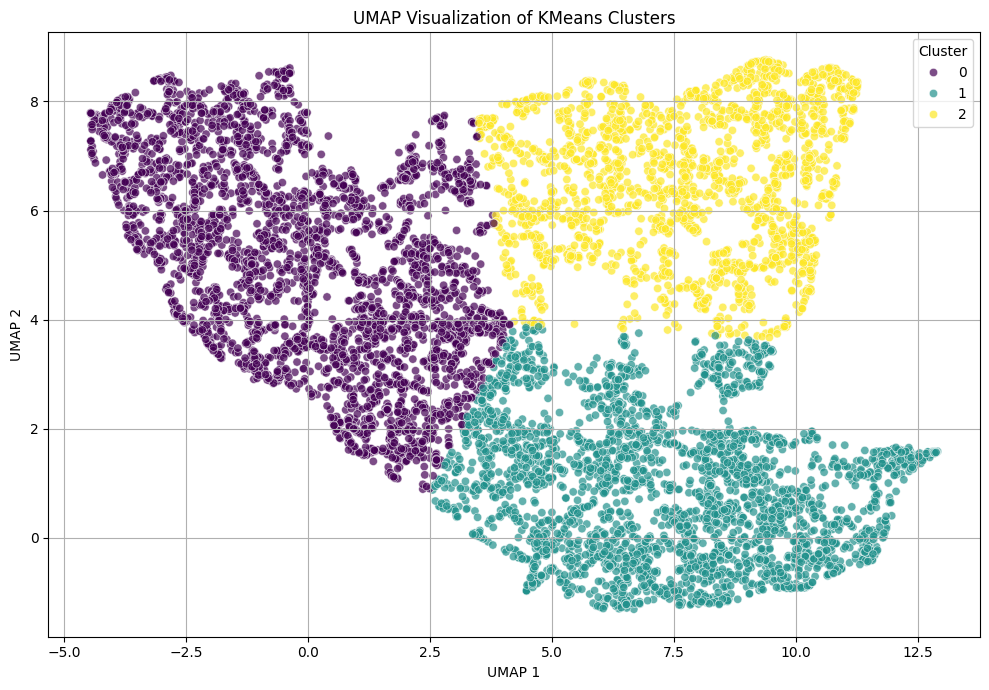

In [ ]:
df['KMeans Cluster'] = clusters4

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(umap_results)
df['KMeans Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 7))
sns.scatterplot(x='UMAP 1', y='UMAP 2', data=df, palette='viridis', alpha=0.7, hue='KMeans Cluster')
plt.title("UMAP Visualization of KMeans Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

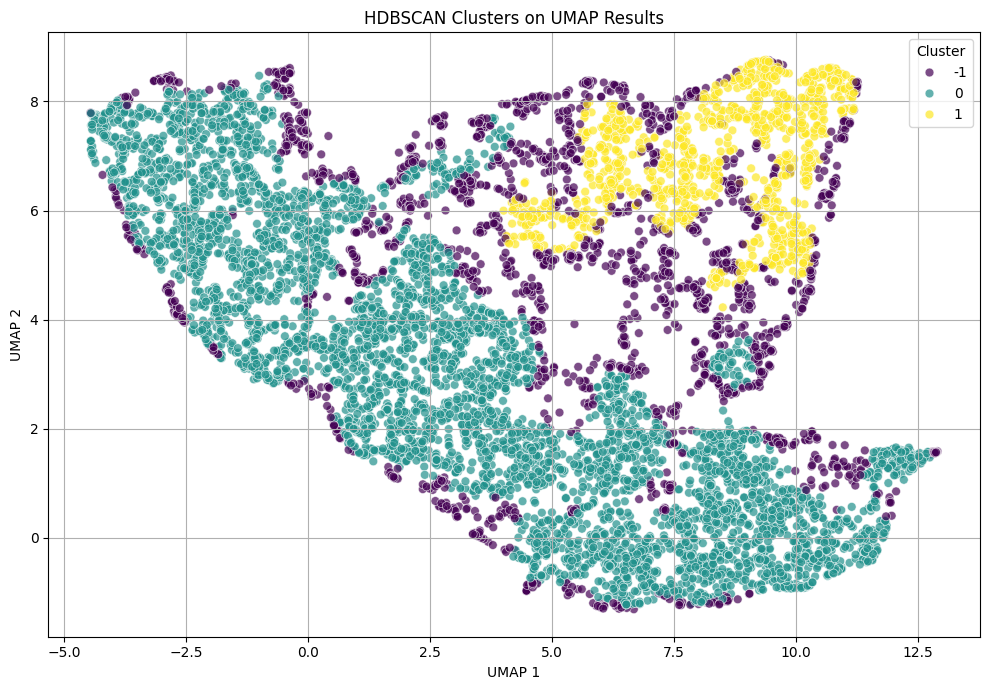

In [ ]:
#check alternative clustering methods (HDBSCAN)
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=100)
hdbscan_clusters = hdbscan.fit_predict(umap_results)

df['HDBSCAN Cluster'] = hdbscan_clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='UMAP 1', y='UMAP 2',
    hue='HDBSCAN Cluster',
    palette='viridis',
    data=df,
    alpha=0.7,
    s=40
)

plt.title("HDBSCAN Clusters on UMAP Results")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

two types of songs? ones moving in the analytic-linguistic dimension and the other focusing on swear-WC (more emotional language)

### Correspondence between clusters and chart behavior

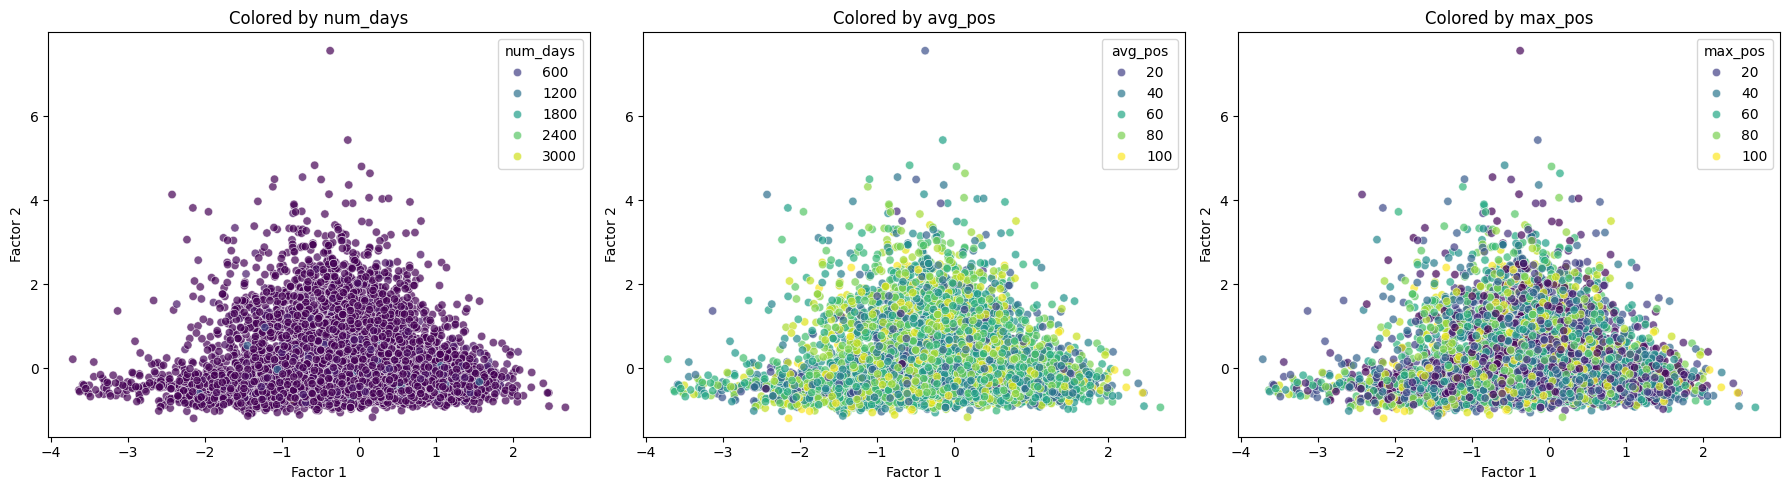

In [ ]:
#color factors by external variables ('num_days', 'avg_pos', 'max_pos')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

sns.scatterplot(x='Factor 1', y='Factor 2', hue='num_days',
                data=df, alpha=0.7, palette='viridis', ax=axes[0])
axes[0].set_title('Colored by num_days')

sns.scatterplot(x='Factor 1', y='Factor 2', hue='avg_pos',
                data=df, alpha=0.7, palette='viridis', ax=axes[1])
axes[1].set_title('Colored by avg_pos')

sns.scatterplot(x='Factor 1', y='Factor 2', hue='max_pos',
                data=df, alpha=0.7, palette='viridis', ax=axes[2])
axes[2].set_title('Colored by max_pos')

plt.tight_layout()
plt.show()

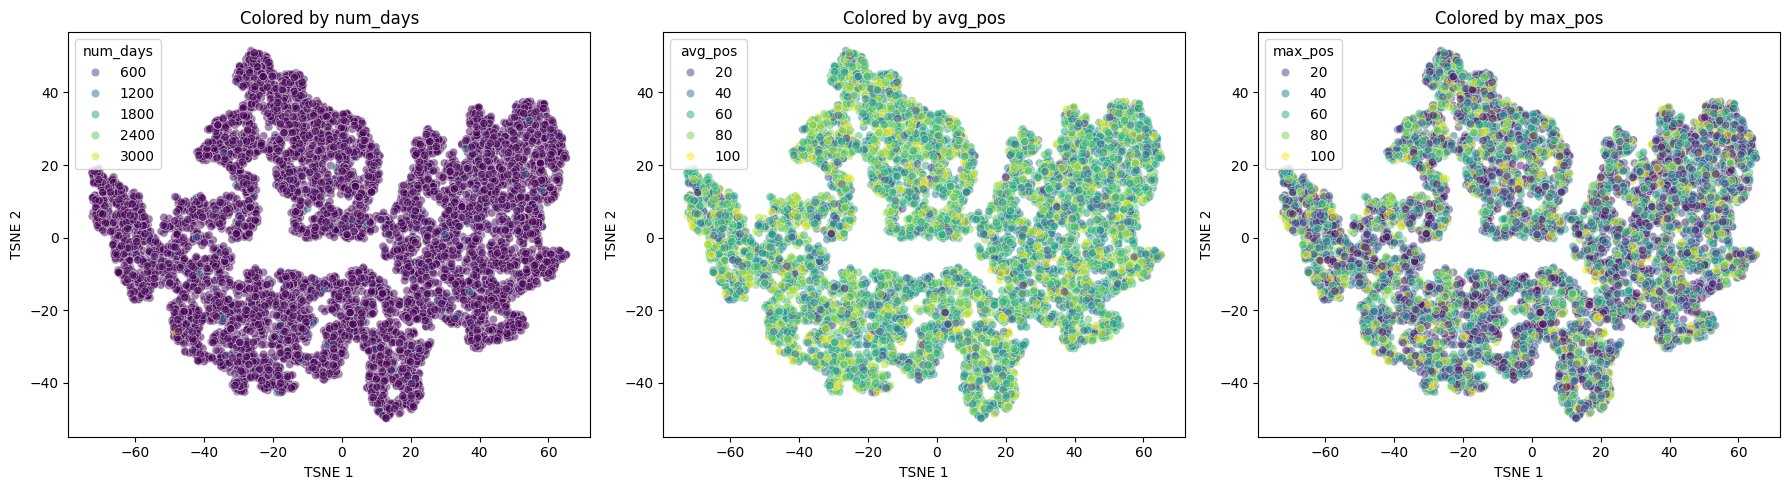

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

sns.scatterplot(x='TSNE 1', y='TSNE 2', hue='num_days',
                data=df, alpha=0.5, palette='viridis', ax=axes[0])
axes[0].set_title('Colored by num_days')

sns.scatterplot(x='TSNE 1', y='TSNE 2', hue='avg_pos',
                data=df, alpha=0.5, palette='viridis', ax=axes[1])
axes[1].set_title('Colored by avg_pos')

sns.scatterplot(x='TSNE 1', y='TSNE 2', hue='max_pos',
                data=df, alpha=0.5, palette='viridis', ax=axes[2])
axes[2].set_title('Colored by max_pos')

plt.tight_layout()
plt.show()

                 num_days    avg_pos    max_pos
kmeans_cluster                                 
0               38.089117  63.306646  43.701498
1               39.607574  62.494918  41.808056
2               23.285168  65.937992  47.047401


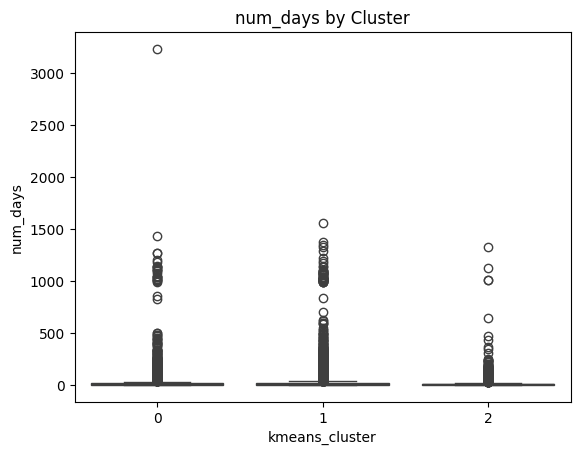

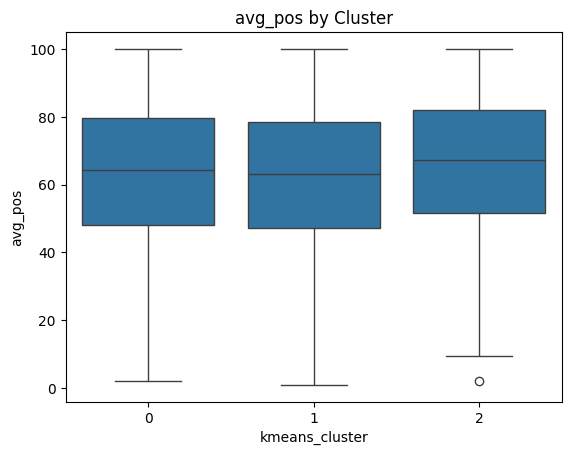

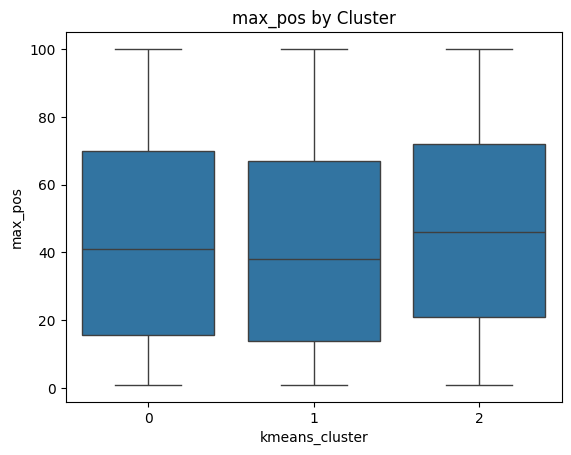

num_days: F=9.51, p=0.0001
avg_pos: F=15.43, p=0.0000
max_pos: F=16.88, p=0.0000


In [ ]:
#check clusters against external variables ()
df['kmeans_cluster'] = clusters4

# 1. Look at summary statistics of chart vars by cluster
summary = df.groupby('kmeans_cluster')[['num_days','avg_pos','max_pos']].mean()
print(summary)

# 2. Check distributions with boxplots
for col in ['num_days','avg_pos','max_pos']:
    sns.boxplot(x='kmeans_cluster', y=col, data=df)
    plt.title(f'{col} by Cluster')
    plt.show()

# 3. Correlation / ANOVA check
import scipy.stats as stats
for col in ['num_days','avg_pos','max_pos']:
    groups = [g[col].values for _, g in df.groupby('kmeans_cluster')]
    fval, pval = stats.f_oneway(*groups)
    print(f'{col}: F={fval:.2f}, p={pval:.4f}')

## Embeddings

embedding lyrics -> umap reduction -> hdbscan

In [1]:
import re
import pandas as pd
from typing import Iterable
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import defaultdict, deque

pop = pd.read_csv('data/songs_kword_LIWC.csv')

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# lemmatizer
lemmatizer = WordNetLemmatizer()             
    
# stopwords
base_sw = set(stopwords.words("english"))
negations = {"no", "not", "nor", "never"}
sw = base_sw - negations
sw |= {
    "yeah", "uh", "la", "oh", "ooh", "na", "nah", "hey", "yo", "ha", "whoa",
    "mmm", "woo", "like", "shit", "go", "get", "know", "want"
}

# helper functions
TOKEN_RE = re.compile(r"[a-z0-9]+(?:'[a-z0-9]+)?")
BRACKETS_RE = re.compile(r"\[[^\]]*\]")

def clean(doc: str, min_token_len: int = 2, remove_digits_only: bool = True) -> str:
    """
    - expand contractions, strip, and turn into lowercase
    - removed bracketed text
    - tokenize
    - remove stopwords, short tokens, and digits
    - lemmatize
    - join the tokens
    """
    if not isinstance(doc, str):
        return ""
    text = contractions.fix(doc).strip().lower()
    text = BRACKETS_RE.sub(" ", text)
    toks = TOKEN_RE.findall(text)
    toks = [t for t in toks
            if (t not in sw)
            and (len(t) >= min_token_len)
            and (not (remove_digits_only and t.isdigit()))]
    lemma = []
    for t in toks:
        n = lemmatizer.lemmatize(t, pos="n")
        v = lemmatizer.lemmatize(n, pos="v")
        lemma.append(v)

    return " ".join(lemma)

def preprocess(texts: Iterable[str]) -> pd.Series:
    """
    - perform text cleaning
    - return a series
    """
    return pd.Series([clean(t) for t in texts], index=getattr(texts, "index", None))

def get_lyrics(pop, idx, lyrics, topic_model, top_n=5, exclude_outliers=True):
    """
    - get indices of lyrics
    - get topic labels
    - print the representative lyrics for each topic
    """
    pos_map = defaultdict(deque)
    for i, text in enumerate(lyrics):
        pos_map[text].append(i)

    info = topic_model.get_topic_info()
    topic_ids = info["Topic"].tolist()
    if exclude_outliers:
        topic_ids = [t for t in topic_ids if t != -1]

    for t in topic_ids:
        reps = topic_model.get_representative_docs(t)[:top_n]
        print(f"\n=== Topic {t} ===")
        for d in reps:
            if pos_map[d]:
                doc_idx = pos_map[d].popleft()        
                orig_index = idx[doc_idx]          
                print(f"[row {orig_index}]")
                print(pop.loc[orig_index, "lyrics"])
            else:
                print("[unmapped] (showing processed text)")
                print(d)
            print("-" * 60)

In [3]:
# preprocess the lyrics
pop_filtered = pop.dropna(subset=["lyrics"])
pop_filtered["processed_lyrics"] = preprocess(pop_filtered["lyrics"])
corpus = pop_filtered["processed_lyrics"].astype(str).str.strip()
mask = corpus.ne("")                       
lyrics = corpus[mask].tolist()
idx  = corpus[mask].index

2 Topics: HBDSCAN + BERTopic 

In [4]:
# set up BERTopic
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

vectorizer_model = CountVectorizer(
    lowercase=False,             
    token_pattern=r"(?u)\b\w+\b",
    stop_words=list(sw),         
    ngram_range=(1, 2),          
    min_df=0.01                     
)

umap_model = UMAP(
    n_neighbors=160,
    min_dist=0,
    n_components=2,
    metric="cosine",
    random_state=13
) 

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=400,
    min_samples=1,
    cluster_selection_epsilon=0.2,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

# fit the model
X = embedding_model.encode(lyrics, show_progress_bar=True, normalize_embeddings=True)
topics, probs = topic_model.fit_transform(lyrics, X)
topic_model.get_topic_info()


Batches: 100%|██████████| 291/291 [01:02<00:00,  4.64it/s]
2025-09-05 01:57:29,585 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-09-05 01:58:07,124 - BERTopic - Dimensionality - Completed ✓
2025-09-05 01:58:07,126 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-05 01:58:07,308 - BERTopic - Cluster - Completed ✓
2025-09-05 01:58:07,315 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-09-05 01:58:09,095 - BERTopic - Representation - Completed ✓


Topic  Count                    Name  \
0     -1   1674      -1_not_love_no_say   
1      0   6120       0_not_love_no_let   
2      1   1496  1_not_nigga_bitch_fuck   

                                      Representation  \
0  [not, love, no, say, make, baby, come, one, le...   
1  [not, love, no, let, baby, say, make, time, fe...   
2  [not, nigga, bitch, fuck, no, make, say, back,...   

                                 Representative_Docs  
0  [first would say good even please many could c...  
1  [pullin makin stronger shakin right core not s...  
2  [bo ale dojeba bite new york stand fuck go nig...

In [5]:
topic_model.visualize_heatmap()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_not_love_no, 1_not_nigga_bitch],
              'xaxis': 'x',
              'y': [0_not_love_no, 1_not_nigga_bitch],
              'yaxis': 'y',
              'z': {'bdata': '//9/P6pwVz+qcFc/AgCAPw==', 'dtype': 'f4', 'shape': '2, 2'}}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Similarity Score'}},
                             'colorscale': [[0.0, 'rgb(247,252,240)'], [0.125,
                                            'rgb(224,243,219)'], [0.25,
                                            'rgb(204,235,197)'], [0.375,
                                            'rgb(168,221,181)'], [0.5,
                                            'rgb(123,204,196)'], [0.625,
                                            'rgb(78,179,211)'], [0.75,
                                            'rgb(43,140,190)'], [0.875,
                                            'rgb(8,104,172)'], [1.0,
                                            'rgb(8,64,129)']]},
               'height': 800,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'title': {'text': 'Trend'}},
               'margin': {'t': 60},
               'showlegend': True,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Similarity Matrix</b>',
                         'x': 0.55,
                         'xanchor': 'center',
                         'y': 0.95,
                         'yanchor': 'top'},
               'width': 800,
               'xaxis': {'anchor': 'y', 'constrain': 'domain', 'domain': [0.0, 1.0], 'scaleanchor': 'y'},
               'yaxis': {'anchor': 'x', 'autorange': 'reversed', 'constrain': 'domain', 'domain': [0.0, 1.0]}}
})

In [14]:
# view representative lyrics
get_lyrics(pop, idx, lyrics, topic_model, top_n=5)


=== Topic 0 ===
[row 4928]
pullin' me further, further than i've been before makin' me stronger, shakin' me right to the core oh, i don't know what's in the stars never heard it from above, the world isn't ours but i know what's in my heart if you ain't mine, i'll be torn apart i don't know who's gonna kiss you when i'm gone so i'm gonna love you now like it's all i have i know it'll kill me when it's over i don't wanna think about it, i want you to love me now i don't know who's gonna kiss you when i'm gone so i'm gonna love you now like it's all i have i know it'll kill me when it's over i don't wanna think about it, i want you to love me now (love me now, love me now) oh, oh, love me now, oh, oh, oh, yeah (love me now, love me now) i want you to love me now somethin' inside us knows there's nothing guaranteed yeah, girl, i don't need you to tell me that you'll never leave, no when we've done all that we could to turn darkness into light, turn evil to good even when we try so hard f

I adjusted the hyperparameters for UMAP and HBDSCAN to reduce noise and produce interpretable topics.<br>
Topic 0 seems to be about the difficult feelings in romance.<br>
Topic 1 seems to be rap/hip-hop.

2 Topics: KMeans + BERTopic

In [15]:
# set up BERTopic
K = 2  

kmeans_model = KMeans(
    n_clusters=K,
    n_init=10,         
    random_state=13
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=kmeans_model,  
    calculate_probabilities=False,
    verbose=True
)

# fit the model
X = embedding_model.encode(lyrics, show_progress_bar=True, normalize_embeddings=True)
topics, _ = topic_model.fit_transform(lyrics, X)
topic_model.get_topic_info()


Batches: 100%|██████████| 291/291 [01:02<00:00,  4.66it/s]
2025-08-29 02:00:36,475 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-29 02:01:07,937 - BERTopic - Dimensionality - Completed ✓
2025-08-29 02:01:07,938 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-08-29 02:01:08,442 - BERTopic - Cluster - Completed ✓
2025-08-29 02:01:08,451 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-08-29 02:01:10,557 - BERTopic - Representation - Completed ✓


Topic  Count                Name  \
0      0   5096   0_not_love_no_say   
1      1   4194  1_not_no_nigga_say   

                                      Representation  \
0  [not, love, no, say, never, feel, let, make, t...   
1  [not, no, nigga, say, make, bitch, baby, come,...   

                                 Representative_Docs  
0  [not love not forget silly phase go call not w...  
1  [woah bitch ayy damn bitch ayy motherfucking f...

In [16]:
# view representative lyrics
get_lyrics(pop, idx, lyrics, topic_model, top_n=5)


=== Topic 0 ===
[row 3975]
i'm not in love, so don't forget it it's just a silly phase i'm going through and just because i call you up don't get me wrong, don't think you've got it made i'm not in love, no no it's because i like to see you, but then again that doesn't mean you mean that much to me so if i call you, don't make a fuss don't tell your friends about the two of us i'm not in love, no no it's because ooh, you'll wait a long time for me ooh, you'll wait a long time ooh, you'll wait a long time for me ooh, you'll wait a long time i'm not in love, so don't forget it it's just a silly phase i'm going through and just because i call you up don't get me wrong, don't think you've got it made i'm not in love i'm not in love
------------------------------------------------------------
[row 3723]
not everyone gets drunk without a drop of wine or a sip of 90 proof, but i do not everybody loves getting caught at red lights they got no one to lean into, but i do you don't know how many

I used KMeans to create 2 clusters for BERTopic.<br>
Topic 0 seems to include the love songs.<br>
Topic 1 seems to be rap/hip-hop.<br>
The results echo what we got from HBDSCAN but Topic 0 could be less emotionally nuanced due to the forced clustering.

3 Topics: HBDSCAN + BERTopic 

In [19]:
# set up BERTopic
umap_model = UMAP(
    n_neighbors=15,
    min_dist=0.01,
    n_components=6,
    metric="cosine",
    random_state=13
) 

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

# fit the model
X = embedding_model.encode(lyrics, show_progress_bar=True, normalize_embeddings=True)
topics, probs = topic_model.fit_transform(lyrics, X)
topic_model.get_topic_info()


Batches: 100%|██████████| 291/291 [01:02<00:00,  4.69it/s]
2025-08-29 15:50:45,968 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-29 15:50:56,614 - BERTopic - Dimensionality - Completed ✓
2025-08-29 15:50:56,616 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-29 15:50:57,029 - BERTopic - Cluster - Completed ✓
2025-08-29 15:50:57,036 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-08-29 15:50:59,316 - BERTopic - Representation - Completed ✓


Topic  Count                   Name  \
0     -1   2977     -1_not_love_no_say   
1      0   2780     0_not_love_no_feel   
2      1   2470   1_not_nigga_bitch_no   
3      2   1063  2_not_night_baby_girl   

                                      Representation  \
0  [not, love, no, say, let, make, baby, time, ta...   
1  [not, love, no, feel, never, say, let, would, ...   
2  [not, nigga, bitch, no, fuck, say, make, back,...   
3  [not, night, baby, girl, love, little, back, o...   

                                 Representative_Docs  
0  [girl give writer's block loss word uhh mind's...  
1  [would tell love tonight get time side go leav...  
2  [cool dre simple complicate complicate think m...  
3  [not dare runnin little town grow not cuss cit...

In [20]:
# view representative lyrics
get_lyrics(pop, idx, lyrics, topic_model, top_n=5)


=== Topic 0 ===
[row 8725]
ooh-ooh, ooh-ooh ooh-ooh, ooh-ooh i would tell you that i love you tonight but i know that i've got time on my side where you goin'? why you leavin' so soon? is there somewhere else that’s better for you? what is love if you're not here with me? what is love if it's not guaranteed? what is love if it just ups and leaves? what is love if you're not here no more? what is love if you're not really sure? what is love? what is love? tell myself i wouldn't cry when you're gone but i know it's easier said than done look at me, look at me choked up now (lookin' choked up now) try to tell you, but it won't come out what is love if you're not here with me? what is love if it's not guaranteed? what is love if it just ups and leaves? what is love if you're not here no more? what is love if you're not really sure? what is love if it just ups and goes? i can't live without ya (i can't live without ya) i can’t live with ya (i can't live with ya) what goes around will come 

I adjusted the hyperparameters for UMAP and HBDSCAN, following the logic of the 2-topic setup.<br>
Topic 0 seems to be about the difficult feelings in romance.<br>
Topic 1 seems to be rap/hip-hop.<br>
Topic 2 seems to be country.

3 Topics: KMeans + BERTopic 

In [23]:
# set up BERTopic
K = 3

kmeans_model = KMeans(
    n_clusters=K,
    n_init=10,         
    random_state=13
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=kmeans_model,  
    calculate_probabilities=False,
    verbose=True
)

# fit the model
X = embedding_model.encode(lyrics, show_progress_bar=True, normalize_embeddings=True)
topics, _ = topic_model.fit_transform(lyrics, X)
topic_model.get_topic_info()

Batches: 100%|██████████| 291/291 [01:03<00:00,  4.55it/s]
2025-08-29 16:02:19,124 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-29 16:02:29,990 - BERTopic - Dimensionality - Completed ✓
2025-08-29 16:02:29,993 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-29 16:02:30,064 - BERTopic - Cluster - Completed ✓
2025-08-29 16:02:30,075 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-08-29 16:02:32,917 - BERTopic - Representation - Completed ✓


Topic  Count                  Name  \
0      0   4332    0_not_love_no_feel   
1      1   2759  1_not_love_baby_come   
2      2   2199  2_not_nigga_bitch_no   

                                      Representation  \
0  [not, love, no, feel, never, say, let, cannot,...   
1  [not, love, baby, come, no, girl, let, night, ...   
2  [not, nigga, bitch, no, fuck, say, make, back,...   

                                 Representative_Docs  
0  [wish could could say goodbye would say want m...  
1  [woah fall love not feel hard meet need time a...  
2  [bo ale dojeba beat new york stand fuck go nig...

In [24]:
# view representative lyrics
get_lyrics(pop, idx, lyrics, topic_model, top_n=5)


=== Topic 0 ===
[row 3949]
wish i could, i could've said goodbye i would've said what i wanted to maybe even cried for you if i knew, it would be the last time i would've broke my heart in two tryin' to save a part of you don't want to feel another touch don't wanna start another fire don't wanna know another kiss no other name falling off my lips don't wanna to give my heart away to another stranger or let another day begin won't even let the sunlight in no, i'll never love again i'll never love again ooouuu ooou oou oh when we first met i never thought that i would fall i never thought that i'd find myself lying in your arms and i want to pretend that it's not true oh baby, that you're gone 'cause my world keeps turning, and turning, and turning and i'm not movin' on don't want to feel another touch don't wanna start another fire don't wanna know another kiss no other name falling off my lips don't wanna give my heart away to another stranger or let another day begin won't even let 

I used KMeans to create 3 clusters for BERTopic.<br>
Topic 0 seems to be about the difficult feelings in romance.<br>
Topic 1 seems to be a combination of love songs & rap/hip-pop. <br>
Topic 2 seems to be rap/hip-hop.<br>
The results echo what we got from HBDSCAN but there are no country songs and Topic 1 lumps together different genres.


Overall, a comparison of the 2-topic setup and the 3-topic setup shows two general themes: love songs & rap/hip-pop. <br>
Depending on the clustering method, many love songs convey sadness, frustration, or longing.

### Factor Analysis with A Larger Dataset

In [89]:
spotify_songs= pd.read_csv("spotify_songs.csv")
songs = spotify_songs[spotify_songs["language"] == "en"]
songs.shape

(15405, 25)

In [90]:
songs= pd.read_csv("songs_liwc.csv")
songs.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre',
       ...
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark', 'Exclam',
       'Apostro', 'OtherP', 'Emoji'],
      dtype='object', length=145)

In [91]:
# Find index of "Text" column
idx = songs.columns.get_loc("Segment")

# Select all columns after it
scores = songs.iloc[:, idx + 1 :]

scores = scores.dropna()

In [92]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

threshold = 1e-5
selector = VarianceThreshold(threshold=threshold)
liwc_reduced = selector.fit_transform(scores)

# Keep only retained columns
kept_columns = scores.columns[selector.get_support()]
liwc_reduced = pd.DataFrame(liwc_reduced, columns=kept_columns)

print(f"After variance filtering: {liwc_reduced.shape}")
print("Dropped columns:", set(scores.columns) - set(kept_columns))

scaler = StandardScaler()
scores_scaled = pd.DataFrame(
    scaler.fit_transform(liwc_reduced),
    columns=liwc_reduced.columns,
)

print(f"After standardization: {scores_scaled.shape}")
scores_scaled.head()


After variance filtering: (14962, 117)
Dropped columns: {'Emoji'}
After standardization: (14962, 117)


WC  Analytic     Clout  Authentic      Tone       WPS  BigWords  \
0 -0.932397  0.675142  0.803557  -0.181059  1.717470 -0.623719 -0.384125   
1 -0.016636 -0.157829  0.979174  -0.961009 -1.134865 -0.827821 -0.750029   
2 -0.265862 -0.766436  0.002460   0.681422  0.853806 -0.617625 -0.090055   
3 -0.236882  2.048419  0.858352  -2.297854 -1.295668  0.730089 -1.097974   
4 -0.210801 -0.755371  0.169310   0.757633 -0.704417  0.771321  0.507064   

        Dic  Linguistic  function  ...    assent    nonflu    filler  \
0  0.099985    0.714477 -0.021933  ... -0.485140 -0.415760 -0.258406   
1 -0.501149   -0.995406 -0.990363  ...  0.075537 -0.091755 -0.258406   
2  0.513100    0.465498  0.382281  ... -0.485140 -0.281530 -0.258406   
3 -5.579010   -3.936542 -4.588593  ...  0.021855 -0.286158 -0.258406   
4  0.989770    1.002110  1.136574  ...  0.839012 -0.156556 -0.258406   

    AllPunc    Period     Comma     QMark    Exclam   Apostro    OtherP  
0 -0.744617 -0.262580  0.610618 -0.506210  1.316385 -1.828402 -0.652378  
1  3.046158  3.073319  0.503783  0.504077  5.423234  1.028447  2.079151  
2 -0.455208 -0.262580 -0.536865  0.547068 -0.236625  0.481986 -0.652378  
3 -1.557907 -0.262580 -1.349995 -0.506210 -0.236625 -1.393774 -0.363336  
4 -0.258017 -0.262580 -0.416182 -0.506210 -0.236625  0.995406 -0.512083  

[5 rows x 117 columns]

In [93]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

chi_square_value,p_value=calculate_bartlett_sphericity(scores_scaled)
chi_square_value, p_value

(1655972.9227675053, 0.0)

In [94]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(scores_scaled)
print("kmo: ", kmo_model)

kmo:  0.43353986644888126


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [95]:
# Prepare for Factor Analysis on the smaller set of columns
scores_filtered = scores_scaled[['Analytic', 'Linguistic',  'Cognition', 'swear', 'WC']]

#does it do better than identity matrix?
chi_square_value, p_value = calculate_bartlett_sphericity(scores_filtered)
print("Bartlett’s Test: p =", p_value, "Chi-square =", chi_square_value)

#KMO calculations
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(scores_filtered)
kmo_model # 0.6 is not very good, 0.7 is acceptable, 0.8 is good, 0.9 is great

Bartlett’s Test: p = 0.0 Chi-square = 17113.21878062614


0.7298543057258284

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


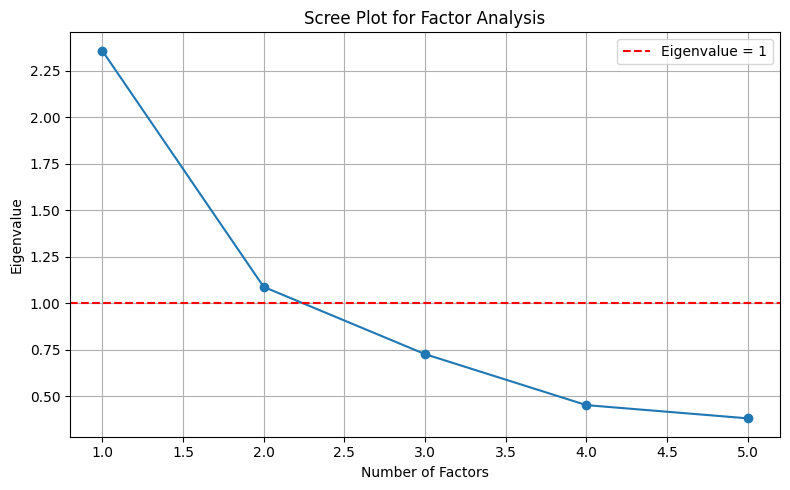

In [96]:
# determine the number of factors
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer

# Fit FactorAnalyzer with max possible factors
fa = FactorAnalyzer(n_factors=scores_filtered.shape[1], rotation='varimax')
fa.fit(scores_filtered)

# Get eigenvalues and plot them
ev, _ = fa.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev)+1), ev, marker='o', linestyle='-')
plt.axhline(1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot for Factor Analysis')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
# factor analysis with 2 factors
fa = FactorAnalyzer(n_factors=2, rotation='varimax') 
fa.fit(scores_filtered)

# Get the variance explained
variance, proportion_variance, cumulative_variance = fa.get_factor_variance()

# Print variance results
print("Variance per factor:", variance)
print("Proportion of variance per factor:", proportion_variance)
print("Cumulative variance (proportion):", cumulative_variance)

Variance per factor: [1.69635416 0.62121457]
Proportion of variance per factor: [0.33927083 0.12424291]
Cumulative variance (proportion): [0.33927083 0.46351374]


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[            Factor 1  Factor 2
swear      -0.207123  0.551269
WC         -0.053338  0.435822
Analytic   -0.794019  0.045229
Linguistic  0.682904 -0.230361
Cognition   0.744167 -0.268820]


<Figure size 1000x600 with 0 Axes>

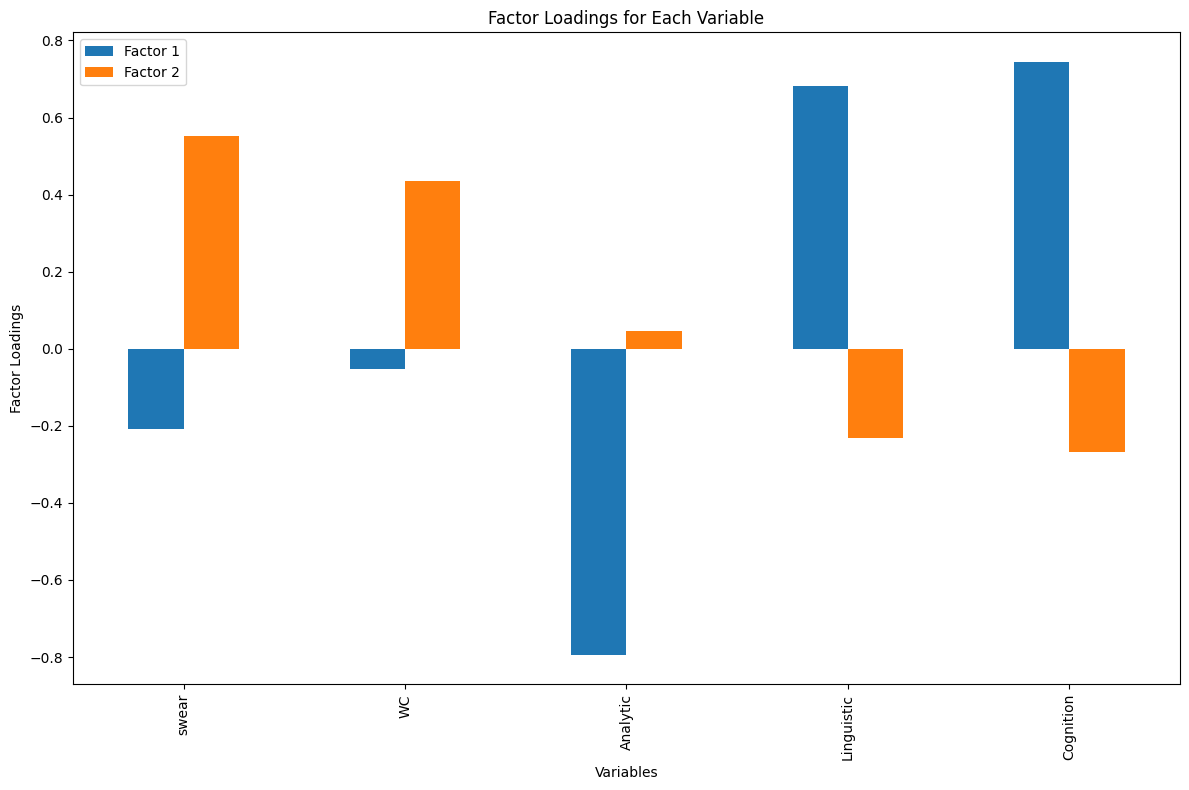

In [98]:
# look at loadings
import seaborn as sns

loadings = fa.loadings_

# Create a DataFrame for factor loadings for easier visualization
loadings_df = pd.DataFrame(loadings, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])], index=scores_filtered.columns)
sorted_loadings_df = loadings_df.sort_values(by='Factor 2', ascending=False)


# Print factor loadings for each variable
print([sorted_loadings_df.head(10)])

# Plot bar chart of loadings for each variable in each factor
plt.figure(figsize=(10, 6))
# Set the axis limits for zooming in
sorted_loadings_df.plot(kind='bar', figsize=(12, 8))
plt.title("Factor Loadings for Each Variable")
plt.xlabel("Variables")
plt.ylabel("Factor Loadings")
plt.xticks(rotation=90)  # Rotate variable names for readability
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


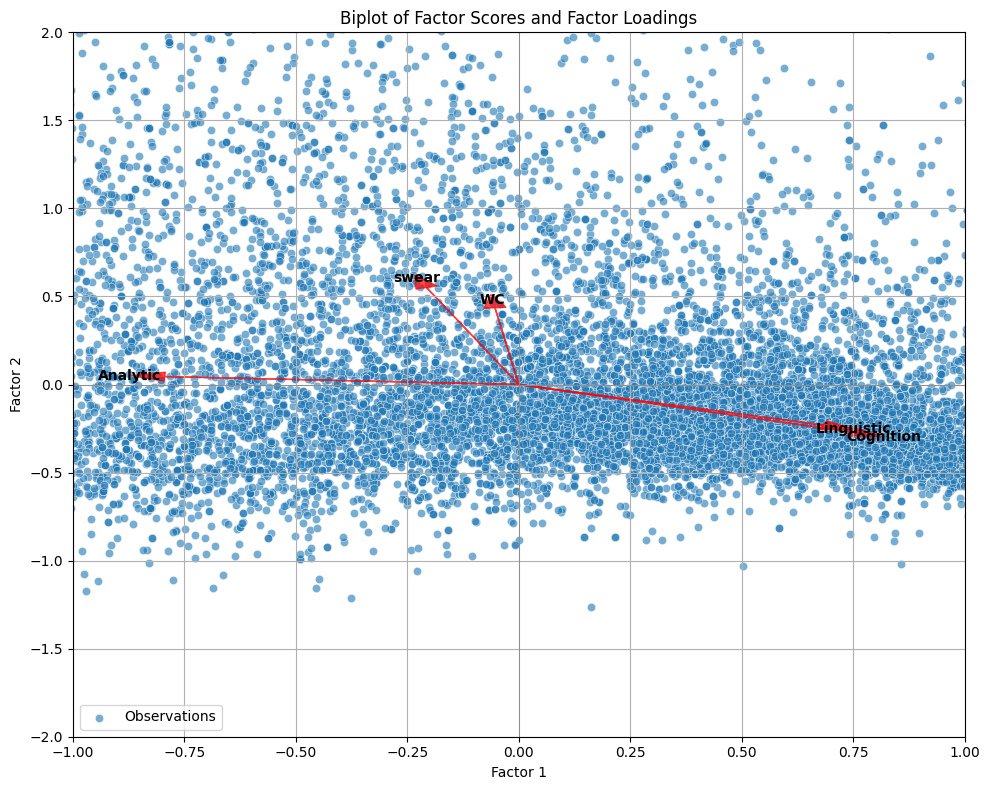

In [99]:
# look more at loadings and results: biplot
# biplot
import matplotlib.pyplot as plt
factor_scores = fa.transform(scores_filtered)

# Create a biplot: Factor scores (observations) and factor loadings (variables)
plt.figure(figsize=(10, 8))

# Plot factor scores
sns.scatterplot(x=factor_scores[:, 0], y=factor_scores[:, 1], alpha=0.6, label='Observations')

# Plot factor loadings (arrows for variables)
for i, var in enumerate(loadings_df.index):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, var, color='black', ha='center', va='center', fontweight='bold')

# Labels and title
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
# Set the axis limits for zooming in
plt.xlim(-1, 1)
plt.ylim(-2, 2)
plt.title('Biplot of Factor Scores and Factor Loadings')
plt.axhline(0, color='gray',linewidth=0.5)
plt.axvline(0, color='gray',linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()


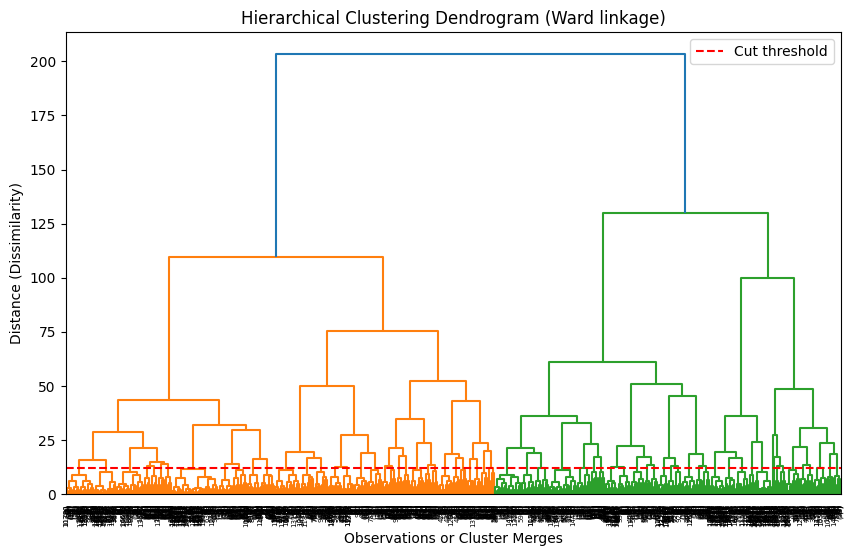

In [100]:
# --- Hierarchical Clustering ---

import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA

# 2️⃣ Compute the linkage matrix
# 'ward' minimizes variance within clusters — great for continuous data
Z = linkage(scores_filtered, method='ward')

# 3️⃣ Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode="level", p=10)  # p=10 = show top merges
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Observations or Cluster Merges")
plt.ylabel("Distance (Dissimilarity)")
plt.axhline(y=12, color='r', linestyle='--', label="Cut threshold")  # optional cutoff
plt.legend()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


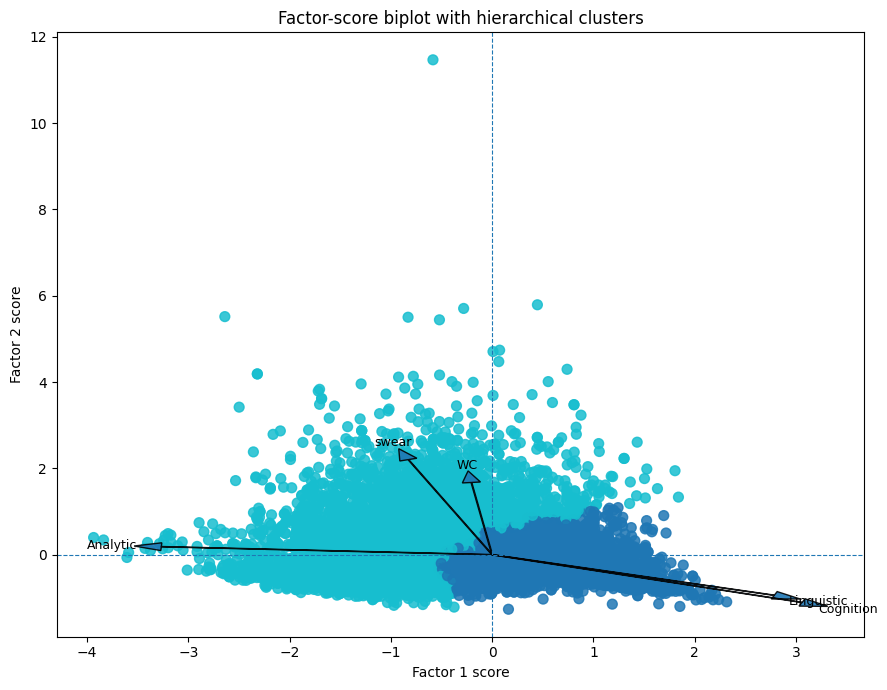

In [101]:
# Get factor scores and loadings
factor_scores = fa.transform(scores_filtered)
loadings = fa.loadings_[:, :2]
var_names = list(scores_filtered.columns)

# --- Add these lines ---
Z = linkage(factor_scores, method='ward')
clusters = fcluster(Z, t=2, criterion='maxclust')   # or use criterion='distance'
# -----------------------

# Plot
plt.figure(figsize=(9,7))
plt.scatter(factor_scores[:,0], factor_scores[:,1], c=clusters, cmap='tab10', s=50, alpha=0.85)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("Factor-score biplot with hierarchical clusters")

# Draw loading arrows
arrow_scale = 0.35 * np.max(np.ptp(factor_scores, axis=0))
for i, (lx, ly) in enumerate(loadings):
    plt.arrow(0, 0, lx*arrow_scale, ly*arrow_scale,
              width=0.008, head_width=0.18, length_includes_head=True, alpha=0.9)
    plt.text(lx*arrow_scale*1.06, ly*arrow_scale*1.06, var_names[i],
             fontsize=9, ha='center', va='center')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


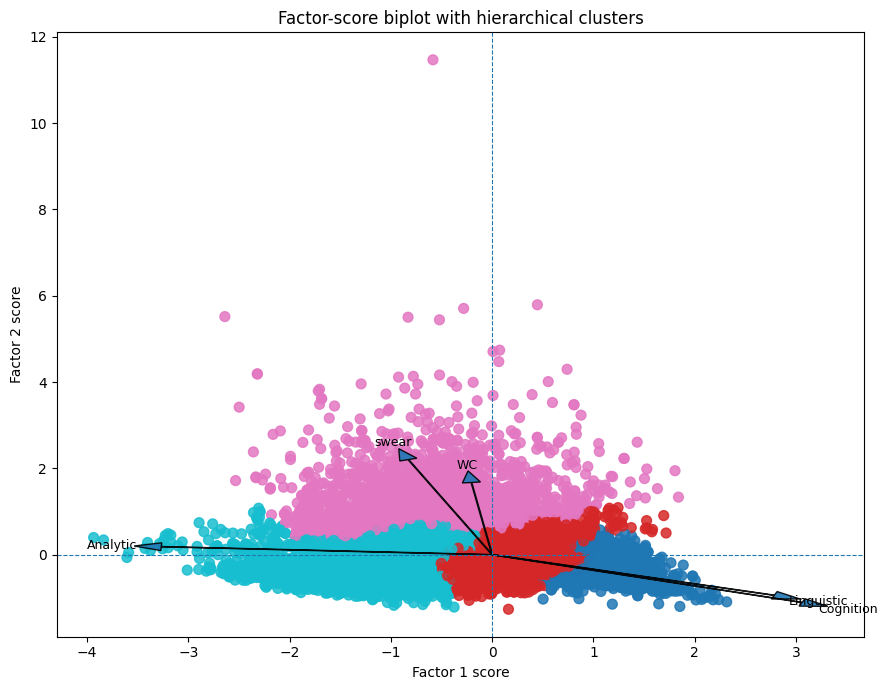

In [102]:
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import numpy as np

# Get factor scores and loadings
factor_scores = fa.transform(scores_filtered)
loadings = fa.loadings_[:, :2]
var_names = list(scores_filtered.columns)

# --- Add these lines ---
Z = linkage(factor_scores, method='ward')
clusters = fcluster(Z, t=4, criterion='maxclust')   # or use criterion='distance'
# -----------------------

# Plot
plt.figure(figsize=(9,7))
plt.scatter(factor_scores[:,0], factor_scores[:,1], c=clusters, cmap='tab10', s=50, alpha=0.85)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("Factor-score biplot with hierarchical clusters")

# Draw loading arrows
arrow_scale = 0.35 * np.max(np.ptp(factor_scores, axis=0))
for i, (lx, ly) in enumerate(loadings):
    plt.arrow(0, 0, lx*arrow_scale, ly*arrow_scale,
              width=0.008, head_width=0.18, length_includes_head=True, alpha=0.9)
    plt.text(lx*arrow_scale*1.06, ly*arrow_scale*1.06, var_names[i],
             fontsize=9, ha='center', va='center')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


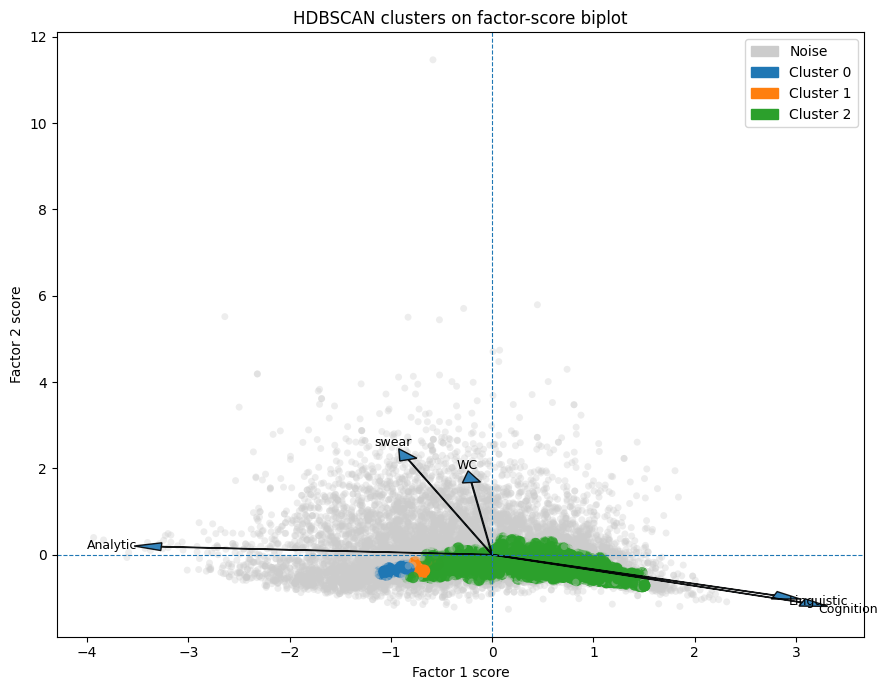

          n  avg_prob
label                
-1     6579  0.000000
 0      140  0.999494
 1      120  1.000000
 2     8123  0.967462


In [103]:
# --- HDBSCAN on factor scores + biplot with loadings ---

import hdbscan

# 1) Get factor scores (2D) and loadings from your fitted FactorAnalyzer `fa`
#    Assumes: fa.fit(pop_num_concise) was already done with n_factors=2
factor_scores = fa.transform(scores_filtered)      # shape: (n_samples, 2)
loadings = fa.loadings_[:, :2]                     # shape: (n_features, 2)
var_names = list(scores_filtered.columns)

# 2) Run HDBSCAN on the factor scores
#    Tune min_cluster_size / min_samples for your data density
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=120,      
    min_samples=5,         
    metric='euclidean',
    cluster_selection_method='eom'  # or 'leaf' for finer splits
)
labels = clusterer.fit_predict(factor_scores)      # -1 = noise
probs  = clusterer.probabilities_                  # membership strength in [0,1]

# 3) Build colors: one color per cluster, noise in light gray
unique_labels = np.unique(labels)
# Map labels (excluding -1) to tab10; noise -> lightgray
label_to_color = {}
palette = plt.cm.tab10.colors
ci = 0
for lab in unique_labels:
    if lab == -1:
        label_to_color[lab] = (0.8, 0.8, 0.8)      # light gray for noise
    else:
        label_to_color[lab] = palette[ci % len(palette)]
        ci += 1
colors = np.array([label_to_color[l] for l in labels])

# Optionally reflect membership strength in alpha/size
alphas = 0.35 + 0.65 * probs   # more confident points look bolder
sizes  = 25  + 55  * probs

# 4) Plot factor-score biplot colored by HDBSCAN clusters
plt.figure(figsize=(9, 7))
plt.scatter(
    factor_scores[:, 0], factor_scores[:, 1],
    c=colors, s=sizes, alpha=alphas, edgecolor='none'
)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("HDBSCAN clusters on factor-score biplot")

# 5) Overlay loading vectors (arrows) for interpretability
score_range = np.max(np.ptp(factor_scores, axis=0))
arrow_scale = 0.35 * score_range   # tweak if arrows too short/long

for i, (lx, ly) in enumerate(loadings):
    x_end = lx * arrow_scale
    y_end = ly * arrow_scale
    plt.arrow(0, 0, x_end, y_end,
              width=0.008, head_width=0.18,
              length_includes_head=True, alpha=0.9)
    plt.text(x_end * 1.06, y_end * 1.06, var_names[i],
             fontsize=9, ha='center', va='center')

# 6) Legend for clusters (including noise)
import matplotlib.patches as mpatches
handles = []
for lab in unique_labels:
    name = "Noise" if lab == -1 else f"Cluster {lab}"
    handles.append(mpatches.Patch(color=label_to_color[lab], label=name))
plt.legend(handles=handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

# 7) (Optional) Inspect cluster sizes and confidences
import pandas as pd
summary = pd.DataFrame({
    "label": labels,
    "prob": probs
}).groupby("label").agg(n=("label", "size"), avg_prob=("prob", "mean")).sort_index()
print(summary)

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


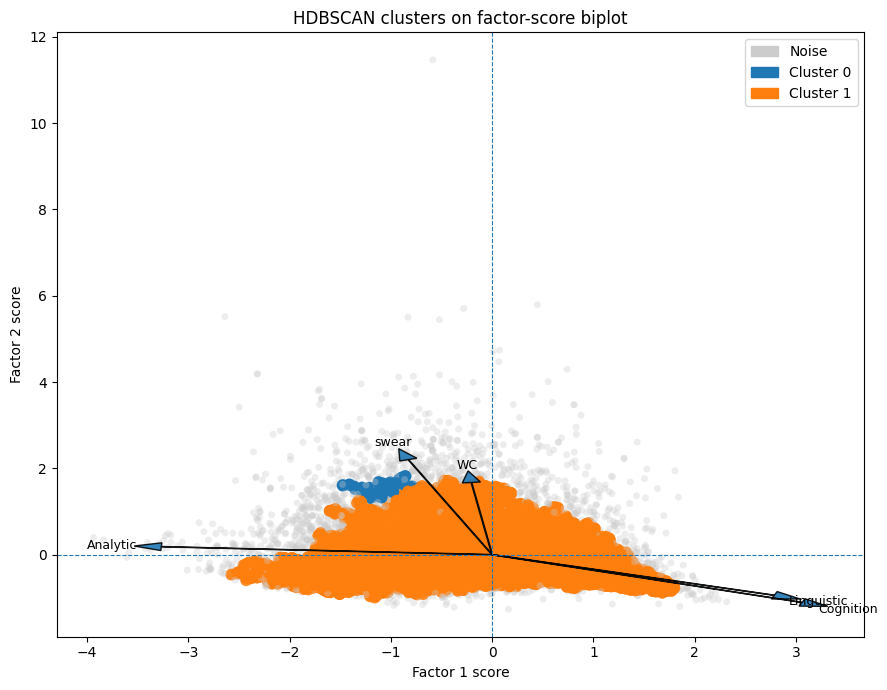

           n  avg_prob
label                 
-1      1246  0.000000
 0        59  0.999858
 1     13657  0.996239


In [104]:
# --- HDBSCAN on factor scores + biplot with loadings ---

# 1) Get factor scores (2D) and loadings from your fitted FactorAnalyzer `fa`
#    Assumes: fa.fit(pop_num_concise) was already done with n_factors=2
factor_scores = fa.transform(scores_filtered)      # shape: (n_samples, 2)
loadings = fa.loadings_[:, :2]                     # shape: (n_features, 2)
var_names = list(scores_filtered.columns)

# 2) Run HDBSCAN on the factor scores
#    Tune min_cluster_size / min_samples for your data density
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,      
    min_samples=5,         
    metric='euclidean',
    cluster_selection_method='eom'  # or 'leaf' for finer splits
)
labels = clusterer.fit_predict(factor_scores)      # -1 = noise
probs  = clusterer.probabilities_                  # membership strength in [0,1]

# 3) Build colors: one color per cluster, noise in light gray
unique_labels = np.unique(labels)
# Map labels (excluding -1) to tab10; noise -> lightgray
label_to_color = {}
palette = plt.cm.tab10.colors
ci = 0
for lab in unique_labels:
    if lab == -1:
        label_to_color[lab] = (0.8, 0.8, 0.8)      # light gray for noise
    else:
        label_to_color[lab] = palette[ci % len(palette)]
        ci += 1
colors = np.array([label_to_color[l] for l in labels])

# Optionally reflect membership strength in alpha/size
alphas = 0.35 + 0.65 * probs   # more confident points look bolder
sizes  = 25  + 55  * probs

# 4) Plot factor-score biplot colored by HDBSCAN clusters
plt.figure(figsize=(9, 7))
plt.scatter(
    factor_scores[:, 0], factor_scores[:, 1],
    c=colors, s=sizes, alpha=alphas, edgecolor='none'
)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("HDBSCAN clusters on factor-score biplot")

# 5) Overlay loading vectors (arrows) for interpretability
score_range = np.max(np.ptp(factor_scores, axis=0))
arrow_scale = 0.35 * score_range   # tweak if arrows too short/long

for i, (lx, ly) in enumerate(loadings):
    x_end = lx * arrow_scale
    y_end = ly * arrow_scale
    plt.arrow(0, 0, x_end, y_end,
              width=0.008, head_width=0.18,
              length_includes_head=True, alpha=0.9)
    plt.text(x_end * 1.06, y_end * 1.06, var_names[i],
             fontsize=9, ha='center', va='center')

# 6) Legend for clusters (including noise)
import matplotlib.patches as mpatches
handles = []
for lab in unique_labels:
    name = "Noise" if lab == -1 else f"Cluster {lab}"
    handles.append(mpatches.Patch(color=label_to_color[lab], label=name))
plt.legend(handles=handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

# 7) (Optional) Inspect cluster sizes and confidences
import pandas as pd
summary = pd.DataFrame({
    "label": labels,
    "prob": probs
}).groupby("label").agg(n=("label", "size"), avg_prob=("prob", "mean")).sort_index()
print(summary)

### Factor Analysis with A Larger Dataset and Column Pruning

I revised the original code for removing low-loading variables. First, I set the threshold to 0.3 and keep looping until all variables have loading scores above the threshold. This step filters out the irrelevant items. Then I increase the threshold to 0.6 and continue looping until the items remain unchanged and stabilized. This step picks out the highly important items.

In [105]:
from factor_analyzer import FactorAnalyzer
import pandas as pd
import numpy as np

# Work on a copy for iterative elimination
pop_num_concise = scores_scaled.copy()

n_factors = 2
threshold = 0.3            # starting threshold
high_threshold = 0.6       # higher threshold once things stabilize
max_rounds = 20            # safety cap
switched_to_high = False   # flag to track when we move to 0.6
final_loadings_df = None   # to store loadings for final round

for round_num in range(1, max_rounds + 1):
    print(f"\n--- Round {round_num} (threshold = {threshold}) ---")
    print(f"Number of variables entering FA: {pop_num_concise.shape[1]}")

    # Fit Factor Analysis
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(pop_num_concise)

    # Get loadings
    loadings = fa.loadings_
    loadings_df = pd.DataFrame(
        loadings,
        index=pop_num_concise.columns,
        columns=[f"Factor{i+1}" for i in range(n_factors)]
    )

    # Save for final display (updated each iteration)
    final_loadings_df = loadings_df.copy()

    # Show top 6 variables by max absolute loading
    loadings_df["max_abs_loading"] = loadings_df.abs().max(axis=1)
    top6 = loadings_df.sort_values("max_abs_loading", ascending=False).head(6)

    print("\nTop 6 variables this round (by max |loading|):")
    print(top6.drop(columns="max_abs_loading"))

    # Identify low-loading items under current threshold
    low_loading_items = [
        pop_num_concise.columns[i]
        for i in range(loadings.shape[0])
        if np.all(np.abs(loadings[i, :]) < threshold)
    ]

    print(f"\nLow-loading items (all |loadings| < {threshold}): {low_loading_items}")

    if not low_loading_items:
        # No variables removed at this threshold
        if not switched_to_high and threshold < high_threshold:
            # First time we hit stability at low threshold → increase to high threshold
            print(
                f"No variables removed at threshold {threshold}. "
                f"Increasing threshold to {high_threshold} for stricter pruning."
            )
            threshold = high_threshold
            switched_to_high = True
            continue
        else:
            # Already at high threshold and still nothing to remove → stabilized
            print(
                f"No variables removed at threshold {threshold}. "
                "Model considered stabilized. Stopping."
            )
            break

    # Drop low-loading items and continue
    pop_num_concise.drop(columns=low_loading_items, inplace=True)
    print(f"Remaining columns after round {round_num}:")
    print(pop_num_concise.columns.tolist())

# === Final ranked output ===
print("\n=== Final set of variables ranked by max |loading| ===")
final_loadings_df["max_abs_loading"] = final_loadings_df.abs().max(axis=1)
ranked = final_loadings_df.sort_values("max_abs_loading", ascending=False)
print(ranked.drop(columns="max_abs_loading"))


--- Round 1 (threshold = 0.3) ---
Number of variables entering FA: 117


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Top 6 variables this round (by max |loading|):
             Factor1   Factor2
Cognition   0.811446 -0.008254
Linguistic  0.807193 -0.031497
function    0.798430 -0.103432
Analytic   -0.766895 -0.324701
Social      0.192914  0.730392
verb        0.710558  0.034090

Low-loading items (all |loadings| < 0.3): ['WC', 'Tone', 'WPS', 'BigWords', 'we', 'shehe', 'they', 'ipron', 'det', 'number', 'conj', 'adj', 'quantity', 'Drives', 'affiliation', 'achieve', 'power', 'allnone', 'cause', 'certitude', 'memory', 'tone_neg', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'prosocial', 'polite', 'conflict', 'moral', 'comm', 'family', 'friend', 'female', 'male', 'Culture', 'politic', 'ethnicity', 'tech', 'Lifestyle', 'leisure', 'home', 'work', 'money', 'relig', 'Physical', 'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 'food', 'death', 'need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue', 'reward', 'risk', 'curiosity', 'allure', 'attention', 'motion', 'visual', 'auditory', 'feeli

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Top 6 variables this round (by max |loading|):
             Factor1   Factor2
Social      0.158217  0.813039
Linguistic  0.810782  0.001781
function    0.791620 -0.017848
Cognition   0.788939  0.023124
Analytic   -0.777756 -0.302074
verb        0.713434  0.039208

Low-loading items (all |loadings| < 0.3): ['prep', 'swear', 'Conversation', 'AllPunc']
Remaining columns after round 2:
['Analytic', 'Clout', 'Authentic', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'you', 'article', 'auxverb', 'adverb', 'negate', 'verb', 'Cognition', 'cogproc', 'insight', 'discrep', 'tentat', 'differ', 'Affect', 'tone_pos', 'emotion', 'emo_pos', 'Social', 'socbehav', 'socrefs', 'Perception', 'space', 'focuspresent']

--- Round 3 (threshold = 0.3) ---
Number of variables entering FA: 31


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Top 6 variables this round (by max |loading|):
             Factor1   Factor2
Social      0.152019  0.838810
Linguistic  0.801556  0.030506
Analytic   -0.788633 -0.261452
Cognition   0.787107  0.011361
function    0.775596  0.026431
verb        0.710520  0.038378

Low-loading items (all |loadings| < 0.3): ['tentat']
Remaining columns after round 3:
['Analytic', 'Clout', 'Authentic', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'you', 'article', 'auxverb', 'adverb', 'negate', 'verb', 'Cognition', 'cogproc', 'insight', 'discrep', 'differ', 'Affect', 'tone_pos', 'emotion', 'emo_pos', 'Social', 'socbehav', 'socrefs', 'Perception', 'space', 'focuspresent']

--- Round 4 (threshold = 0.3) ---
Number of variables entering FA: 30


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Top 6 variables this round (by max |loading|):
             Factor1   Factor2
Social      0.155046  0.837832
Linguistic  0.803275  0.026165
Analytic   -0.791935 -0.257238
Cognition   0.781004  0.010403
function    0.775262  0.022829
verb        0.714499  0.033906

Low-loading items (all |loadings| < 0.3): []
No variables removed at threshold 0.3. Increasing threshold to 0.6 for stricter pruning.

--- Round 5 (threshold = 0.6) ---
Number of variables entering FA: 30


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Top 6 variables this round (by max |loading|):
             Factor1   Factor2
Social      0.155046  0.837832
Linguistic  0.803275  0.026165
Analytic   -0.791935 -0.257238
Cognition   0.781004  0.010403
function    0.775262  0.022829
verb        0.714499  0.033906

Low-loading items (all |loadings| < 0.6): ['Clout', 'Authentic', 'i', 'you', 'article', 'adverb', 'negate', 'insight', 'discrep', 'differ', 'Affect', 'tone_pos', 'emotion', 'emo_pos', 'socbehav', 'Perception', 'space', 'focuspresent']
Remaining columns after round 5:
['Analytic', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'auxverb', 'verb', 'Cognition', 'cogproc', 'Social', 'socrefs']

--- Round 6 (threshold = 0.6) ---
Number of variables entering FA: 12

Top 6 variables this round (by max |loading|):
             Factor1   Factor2
socrefs     0.028012  0.856480
Social      0.046059  0.849845
Linguistic  0.826483  0.162893
Cognition   0.799670  0.016394
function    0.769705  0.196318
verb        0.745133  0.101602


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Top 6 variables this round (by max |loading|):
             Factor1   Factor2
Social      0.104000  0.988437
socrefs     0.104510  0.847799
Linguistic  0.835625  0.092930
Cognition   0.813344  0.009321
function    0.773369  0.110977
verb        0.759343  0.076762

Low-loading items (all |loadings| < 0.6): []
No variables removed at threshold 0.6. Model considered stabilized. Stopping.

=== Final set of variables ranked by max |loading| ===
             Factor1   Factor2
Social      0.104000  0.988437
socrefs     0.104510  0.847799
Linguistic  0.835625  0.092930
Cognition   0.813344  0.009321
function    0.773369  0.110977
verb        0.759343  0.076762
Dic         0.723624  0.201040
Analytic   -0.699196 -0.238885
auxverb     0.690432  0.067398
cogproc     0.622223  0.043260


In [106]:
# Prepare for Factor Analysis on the smaller set of columns
scores_scaled = pop_num_concise

#does it do better than identity matrix?
chi_square_value, p_value = calculate_bartlett_sphericity(scores_scaled)
print("Bartlett’s Test: p =", p_value, "Chi-square =", chi_square_value)

#KMO calculations
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(scores_scaled)
kmo_model # 0.6 is not very good, 0.7 is acceptable, 0.8 is good, 0.9 is great

Bartlett’s Test: p = 0.0 Chi-square = 109853.6085375957


0.7469861992941961

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


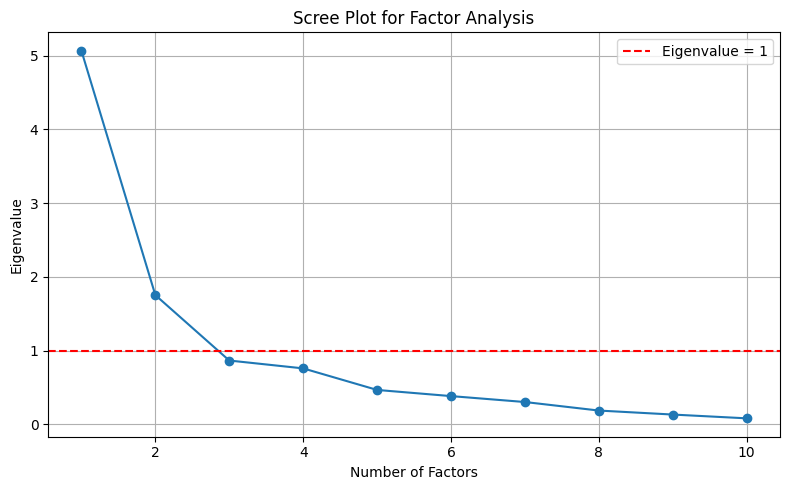

In [107]:
# determine the number of factors
import matplotlib.pyplot as plt

# Fit FactorAnalyzer with max possible factors
fa = FactorAnalyzer(n_factors=scores_scaled.shape[1], rotation='varimax')
fa.fit(scores_scaled)

# Get eigenvalues and plot them
ev, _ = fa.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev)+1), ev, marker='o', linestyle='-')
plt.axhline(1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot for Factor Analysis')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
# factor analysis with 2 factors
fa = FactorAnalyzer(n_factors=2, rotation='varimax') 
fa.fit(scores_scaled)

# Get the variance explained
variance, proportion_variance, cumulative_variance = fa.get_factor_variance()

# Print variance results
print("Variance per factor:", variance)
print("Proportion of variance per factor:", proportion_variance)
print("Cumulative variance (proportion):", cumulative_variance)

Variance per factor: [4.43260041 1.82659973]
Proportion of variance per factor: [0.44326004 0.18265997]
Cumulative variance (proportion): [0.44326004 0.62592001]


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[            Factor 1  Factor 2
Social      0.104000  0.988437
socrefs     0.104510  0.847799
Dic         0.723624  0.201040
function    0.773369  0.110977
Linguistic  0.835625  0.092930
verb        0.759343  0.076762
auxverb     0.690432  0.067398
cogproc     0.622223  0.043260
Cognition   0.813344  0.009321
Analytic   -0.699196 -0.238885]


<Figure size 1000x600 with 0 Axes>

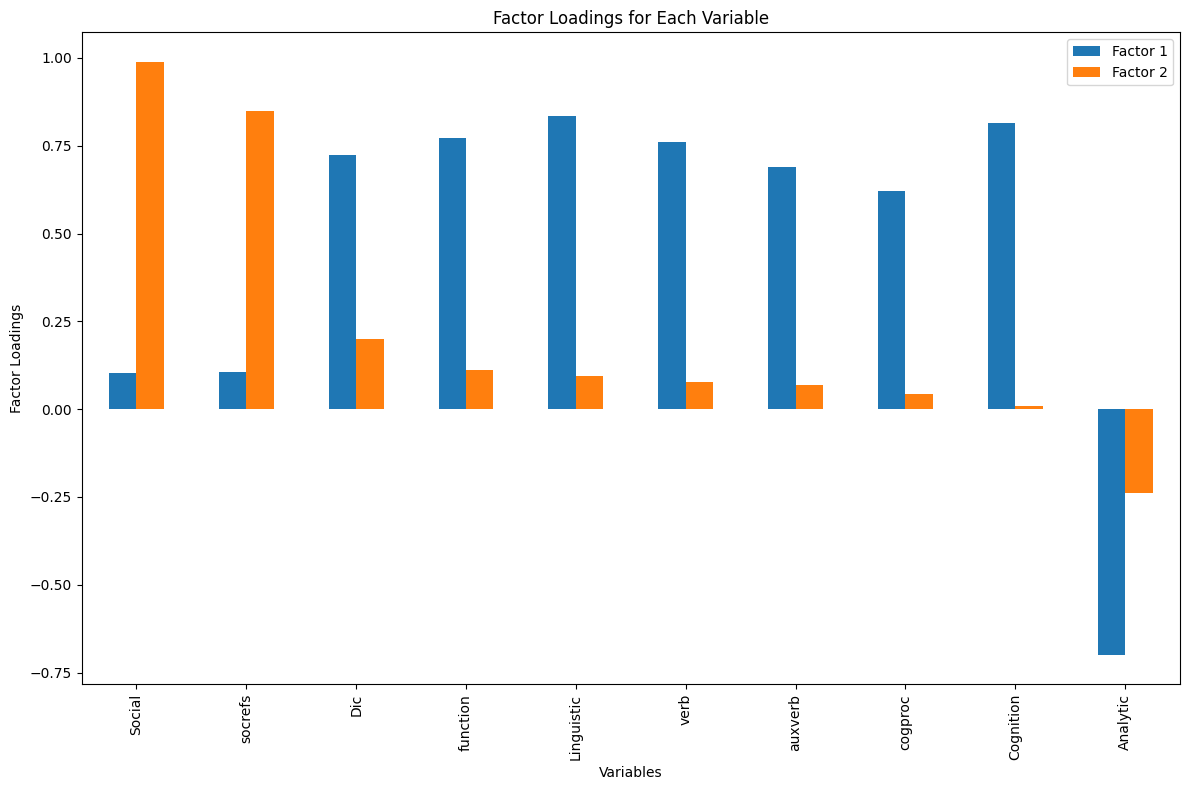

In [109]:
# look at loadings
import seaborn as sns

loadings = fa.loadings_

# Create a DataFrame for factor loadings for easier visualization
loadings_df = pd.DataFrame(loadings, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])], index=scores_scaled.columns)
sorted_loadings_df = loadings_df.sort_values(by='Factor 2', ascending=False)


# Print factor loadings for each variable
print([sorted_loadings_df.head(10)])

# Plot bar chart of loadings for each variable in each factor
plt.figure(figsize=(10, 6))
# Set the axis limits for zooming in
sorted_loadings_df.plot(kind='bar', figsize=(12, 8))
plt.title("Factor Loadings for Each Variable")
plt.xlabel("Variables")
plt.ylabel("Factor Loadings")
plt.xticks(rotation=90)  # Rotate variable names for readability
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


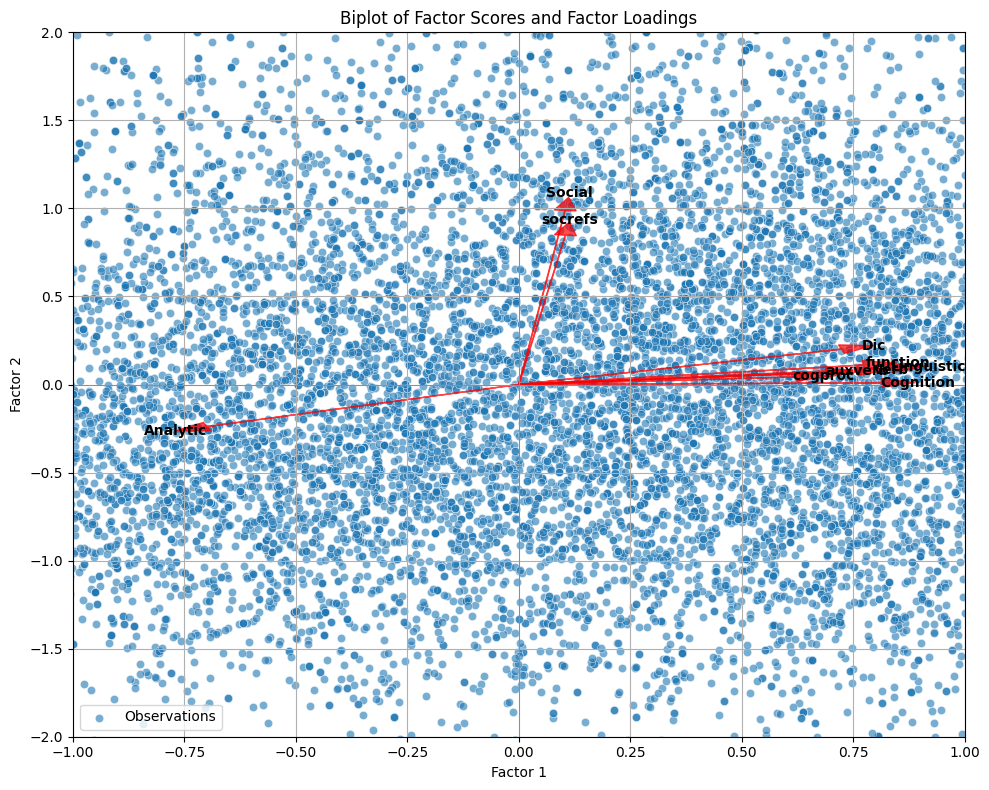

In [110]:
# look more at loadings and results: biplot
# biplot
import matplotlib.pyplot as plt
factor_scores = fa.transform(scores_scaled)

# Create a biplot: Factor scores (observations) and factor loadings (variables)
plt.figure(figsize=(10, 8))

# Plot factor scores
sns.scatterplot(x=factor_scores[:, 0], y=factor_scores[:, 1], alpha=0.6, label='Observations')

# Plot factor loadings (arrows for variables)
for i, var in enumerate(loadings_df.index):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, var, color='black', ha='center', va='center', fontweight='bold')

# Labels and title
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
# Set the axis limits for zooming in
plt.xlim(-1, 1)
plt.ylim(-2, 2)
plt.title('Biplot of Factor Scores and Factor Loadings')
plt.axhline(0, color='gray',linewidth=0.5)
plt.axvline(0, color='gray',linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


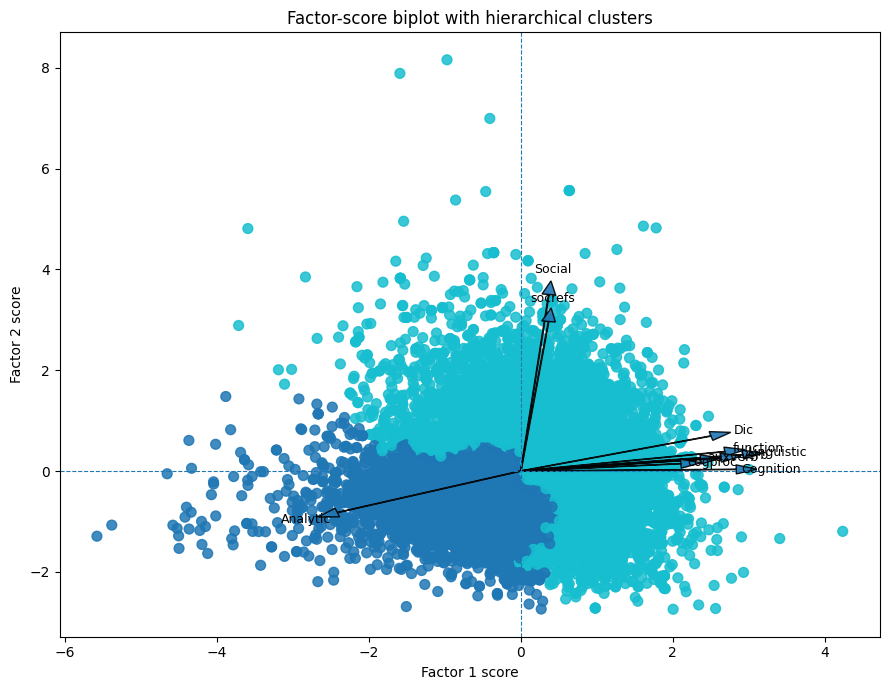

In [112]:
# Get factor scores and loadings
factor_scores = fa.transform(scores_scaled)
loadings = fa.loadings_[:, :2]
var_names = list(scores_scaled.columns)

# --- Add these lines ---
Z = linkage(factor_scores, method='ward')
clusters = fcluster(Z, t=2, criterion='maxclust')   # or use criterion='distance'
# -----------------------

# Plot
plt.figure(figsize=(9,7))
plt.scatter(factor_scores[:,0], factor_scores[:,1], c=clusters, cmap='tab10', s=50, alpha=0.85)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("Factor-score biplot with hierarchical clusters")

# Draw loading arrows
arrow_scale = 0.35 * np.max(np.ptp(factor_scores, axis=0))
for i, (lx, ly) in enumerate(loadings):
    plt.arrow(0, 0, lx*arrow_scale, ly*arrow_scale,
              width=0.008, head_width=0.18, length_includes_head=True, alpha=0.9)
    plt.text(lx*arrow_scale*1.06, ly*arrow_scale*1.06, var_names[i],
             fontsize=9, ha='center', va='center')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


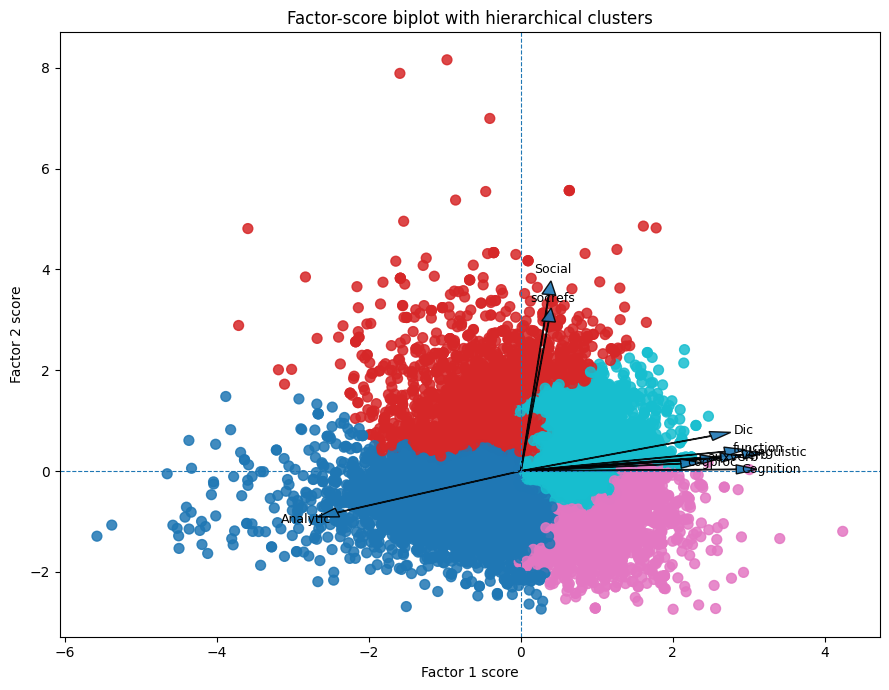

In [111]:
# Get factor scores and loadings
factor_scores = fa.transform(scores_scaled)
loadings = fa.loadings_[:, :2]
var_names = list(scores_scaled.columns)

# --- Add these lines ---
Z = linkage(factor_scores, method='ward')
clusters = fcluster(Z, t=4, criterion='maxclust')   # or use criterion='distance'
# -----------------------

# Plot
plt.figure(figsize=(9,7))
plt.scatter(factor_scores[:,0], factor_scores[:,1], c=clusters, cmap='tab10', s=50, alpha=0.85)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("Factor-score biplot with hierarchical clusters")

# Draw loading arrows
arrow_scale = 0.35 * np.max(np.ptp(factor_scores, axis=0))
for i, (lx, ly) in enumerate(loadings):
    plt.arrow(0, 0, lx*arrow_scale, ly*arrow_scale,
              width=0.008, head_width=0.18, length_includes_head=True, alpha=0.9)
    plt.text(lx*arrow_scale*1.06, ly*arrow_scale*1.06, var_names[i],
             fontsize=9, ha='center', va='center')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


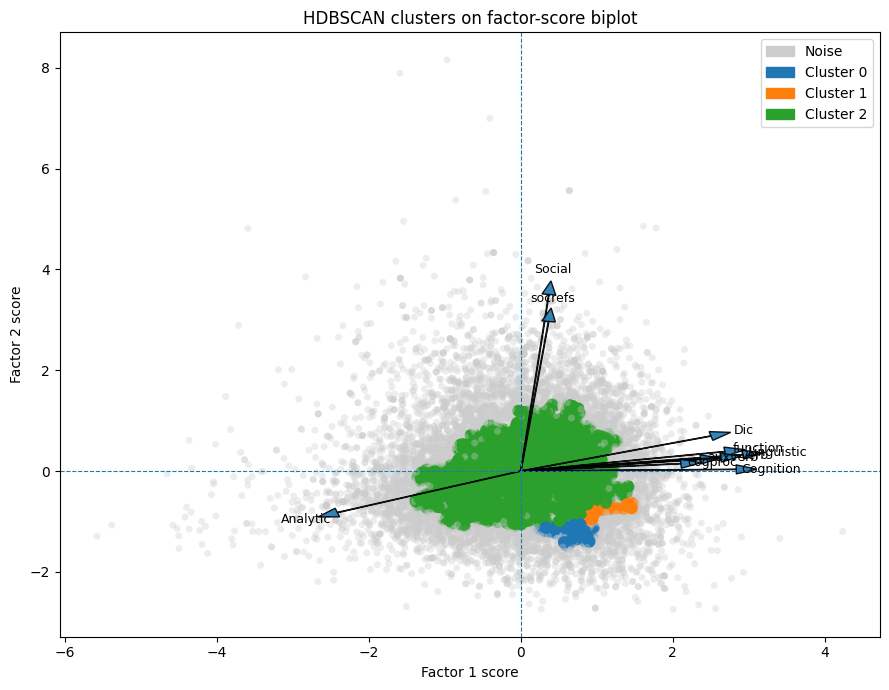

          n  avg_prob
label                
-1     6601  0.000000
 0      241  0.991993
 1      147  0.992505
 2     7973  0.982093


In [113]:
# --- HDBSCAN on factor scores + biplot with loadings ---

import hdbscan

# 1) Get factor scores (2D) and loadings from your fitted FactorAnalyzer `fa`
#    Assumes: fa.fit(pop_num_concise) was already done with n_factors=2
factor_scores = fa.transform(scores_scaled)      # shape: (n_samples, 2)
loadings = fa.loadings_[:, :2]                     # shape: (n_features, 2)
var_names = list(scores_scaled.columns)

# 2) Run HDBSCAN on the factor scores
#    Tune min_cluster_size / min_samples for your data density
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=120,      
    min_samples=5,         
    metric='euclidean',
    cluster_selection_method='eom'  # or 'leaf' for finer splits
)
labels = clusterer.fit_predict(factor_scores)      # -1 = noise
probs  = clusterer.probabilities_                  # membership strength in [0,1]

# 3) Build colors: one color per cluster, noise in light gray
unique_labels = np.unique(labels)
# Map labels (excluding -1) to tab10; noise -> lightgray
label_to_color = {}
palette = plt.cm.tab10.colors
ci = 0
for lab in unique_labels:
    if lab == -1:
        label_to_color[lab] = (0.8, 0.8, 0.8)      # light gray for noise
    else:
        label_to_color[lab] = palette[ci % len(palette)]
        ci += 1
colors = np.array([label_to_color[l] for l in labels])

# Optionally reflect membership strength in alpha/size
alphas = 0.35 + 0.65 * probs   # more confident points look bolder
sizes  = 25  + 55  * probs

# 4) Plot factor-score biplot colored by HDBSCAN clusters
plt.figure(figsize=(9, 7))
plt.scatter(
    factor_scores[:, 0], factor_scores[:, 1],
    c=colors, s=sizes, alpha=alphas, edgecolor='none'
)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("HDBSCAN clusters on factor-score biplot")

# 5) Overlay loading vectors (arrows) for interpretability
score_range = np.max(np.ptp(factor_scores, axis=0))
arrow_scale = 0.35 * score_range   # tweak if arrows too short/long

for i, (lx, ly) in enumerate(loadings):
    x_end = lx * arrow_scale
    y_end = ly * arrow_scale
    plt.arrow(0, 0, x_end, y_end,
              width=0.008, head_width=0.18,
              length_includes_head=True, alpha=0.9)
    plt.text(x_end * 1.06, y_end * 1.06, var_names[i],
             fontsize=9, ha='center', va='center')

# 6) Legend for clusters (including noise)
import matplotlib.patches as mpatches
handles = []
for lab in unique_labels:
    name = "Noise" if lab == -1 else f"Cluster {lab}"
    handles.append(mpatches.Patch(color=label_to_color[lab], label=name))
plt.legend(handles=handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

# 7) (Optional) Inspect cluster sizes and confidences
import pandas as pd
summary = pd.DataFrame({
    "label": labels,
    "prob": probs
}).groupby("label").agg(n=("label", "size"), avg_prob=("prob", "mean")).sort_index()
print(summary)

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


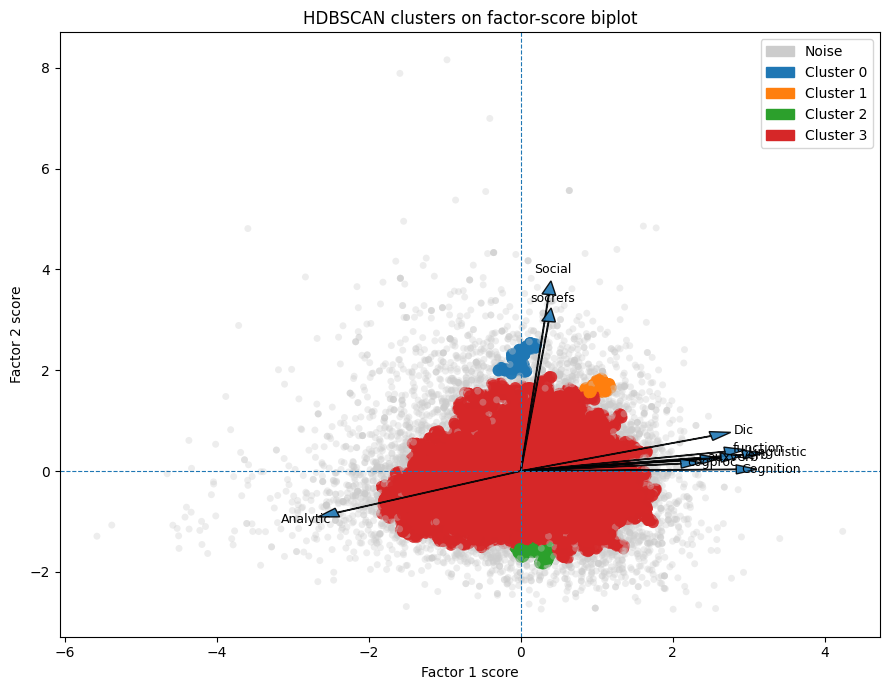

           n  avg_prob
label                 
-1      2959  0.000000
 0        62  0.995209
 1        40  1.000000
 2        87  0.994221
 3     11814  0.988130


In [114]:
# --- HDBSCAN on factor scores + biplot with loadings ---

# 1) Get factor scores (2D) and loadings from your fitted FactorAnalyzer `fa`
#    Assumes: fa.fit(pop_num_concise) was already done with n_factors=2
factor_scores = fa.transform(scores_scaled)      # shape: (n_samples, 2)
loadings = fa.loadings_[:, :2]                     # shape: (n_features, 2)
var_names = list(scores_scaled.columns)

# 2) Run HDBSCAN on the factor scores
#    Tune min_cluster_size / min_samples for your data density
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,      
    min_samples=5,         
    metric='euclidean',
    cluster_selection_method='eom'  # or 'leaf' for finer splits
)
labels = clusterer.fit_predict(factor_scores)      # -1 = noise
probs  = clusterer.probabilities_                  # membership strength in [0,1]

# 3) Build colors: one color per cluster, noise in light gray
unique_labels = np.unique(labels)
# Map labels (excluding -1) to tab10; noise -> lightgray
label_to_color = {}
palette = plt.cm.tab10.colors
ci = 0
for lab in unique_labels:
    if lab == -1:
        label_to_color[lab] = (0.8, 0.8, 0.8)      # light gray for noise
    else:
        label_to_color[lab] = palette[ci % len(palette)]
        ci += 1
colors = np.array([label_to_color[l] for l in labels])

# Optionally reflect membership strength in alpha/size
alphas = 0.35 + 0.65 * probs   # more confident points look bolder
sizes  = 25  + 55  * probs

# 4) Plot factor-score biplot colored by HDBSCAN clusters
plt.figure(figsize=(9, 7))
plt.scatter(
    factor_scores[:, 0], factor_scores[:, 1],
    c=colors, s=sizes, alpha=alphas, edgecolor='none'
)
plt.axhline(0, linewidth=0.8, linestyle='--')
plt.axvline(0, linewidth=0.8, linestyle='--')
plt.xlabel("Factor 1 score")
plt.ylabel("Factor 2 score")
plt.title("HDBSCAN clusters on factor-score biplot")

# 5) Overlay loading vectors (arrows) for interpretability
score_range = np.max(np.ptp(factor_scores, axis=0))
arrow_scale = 0.35 * score_range   # tweak if arrows too short/long

for i, (lx, ly) in enumerate(loadings):
    x_end = lx * arrow_scale
    y_end = ly * arrow_scale
    plt.arrow(0, 0, x_end, y_end,
              width=0.008, head_width=0.18,
              length_includes_head=True, alpha=0.9)
    plt.text(x_end * 1.06, y_end * 1.06, var_names[i],
             fontsize=9, ha='center', va='center')

# 6) Legend for clusters (including noise)
import matplotlib.patches as mpatches
handles = []
for lab in unique_labels:
    name = "Noise" if lab == -1 else f"Cluster {lab}"
    handles.append(mpatches.Patch(color=label_to_color[lab], label=name))
plt.legend(handles=handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

# 7) (Optional) Inspect cluster sizes and confidences
import pandas as pd
summary = pd.DataFrame({
    "label": labels,
    "prob": probs
}).groupby("label").agg(n=("label", "size"), avg_prob=("prob", "mean")).sort_index()
print(summary)

### Correlation of Analytic, Linguistic, and Cognition

In [3]:
pop_large = pd.read_csv('songs_liwc.csv')

In [6]:
cols = ["Analytic", "Cognition", "Linguistic"]
corr_matrix = pop_large[cols].corr()
print(corr_matrix)

            Analytic  Cognition  Linguistic
Analytic    1.000000  -0.603323   -0.537843
Cognition  -0.603323   1.000000    0.549755
Linguistic -0.537843   0.549755    1.000000


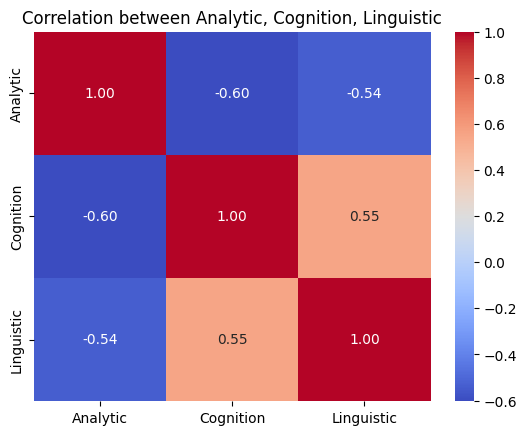

In [8]:
sns.heatmap(pop_large[cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Analytic, Cognition, Linguistic")
plt.show()

In [10]:
pop = pd.read_csv('data/songs_kword_LIWC.csv')

In [11]:
cols = ["Analytic", "Cognition", "Linguistic"]
corr_matrix = pop[cols].corr()
print(corr_matrix)

            Analytic  Cognition  Linguistic
Analytic    1.000000  -0.530590   -0.546022
Cognition  -0.530590   1.000000    0.525103
Linguistic -0.546022   0.525103    1.000000


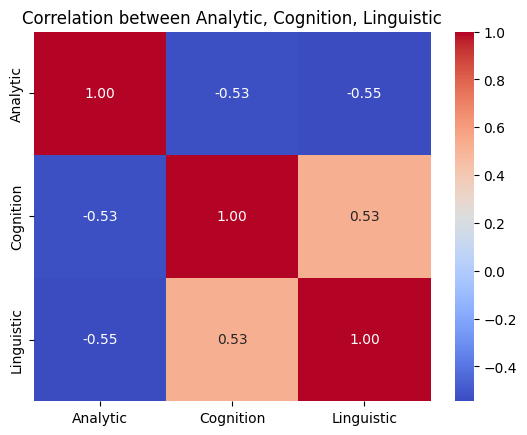

In [12]:
sns.heatmap(pop[cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Analytic, Cognition, Linguistic")
plt.show()

In [3]:
office = pd.read_csv('counter_factual/office_liwc.csv')

In [4]:
cols = ["Analytic", "Cognition", "Linguistic"]
corr_matrix = office[cols].corr()
print(corr_matrix)

            Analytic  Cognition  Linguistic
Analytic    1.000000  -0.601052   -0.744731
Cognition  -0.601052   1.000000    0.580642
Linguistic -0.744731   0.580642    1.000000


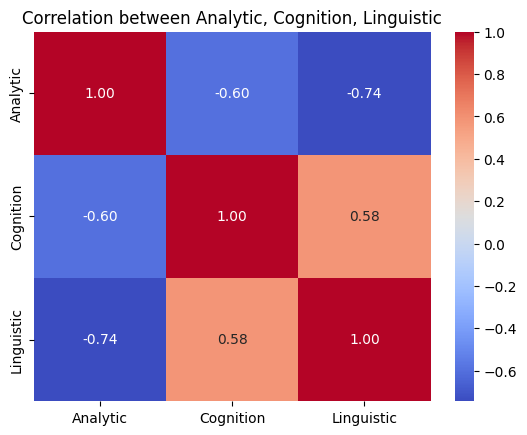

In [9]:
sns.heatmap(office[cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Analytic, Cognition, Linguistic")
plt.show()